# Stationrank

In [1]:
import os
import gc
import time
import json
import scipy
import pickle
#import pygraphviz

In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
import datetime as dt
import networkx as nx
import ipywidgets as widgets
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import warnings
warnings.filterwarnings('ignore')

In [3]:
from networkx.drawing.nx_agraph import write_dot
from networkx.readwrite import json_graph
#from shapely.geometry import Point, LineString
#from shapely_geojson import dump, dumps, Feature, FeatureCollection
from tqdm.notebook import trange, tqdm
from scipy.linalg import norm
from scipy.linalg import eig
from matplotlib import cm
from ipywidgets import interact, interact_manual
from itertools import compress
from itertools import groupby
from operator import itemgetter
from datetime import datetime, timedelta
from sklearn import preprocessing
from numpy import linalg as LA
from numpy import nan

## Loading the dataset

In [4]:
# Set month
month = 'Oktober'

# Set index
imonth = '10'

In [5]:
# Clean data contains every "stop" for a month for all swiss railways
data = pd.read_pickle('data/istdaten/{}/data_clean_2019{}.pkl'.format(month, imonth))

In [6]:
# Check if all days are in
print(data.BETRIEBSTAG.unique())

['01.10.2019' '02.10.2019' '03.10.2019' '04.10.2019' '05.10.2019'
 '06.10.2019' '07.10.2019' '08.10.2019' '09.10.2019' '10.10.2019'
 '11.10.2019' '12.10.2019' '13.10.2019' '14.10.2019' '15.10.2019'
 '16.10.2019' '17.10.2019' '18.10.2019' '19.10.2019' '20.10.2019'
 '21.10.2019' '22.10.2019' '23.10.2019' '24.10.2019' '25.10.2019'
 '26.10.2019' '27.10.2019' '28.10.2019' '29.10.2019' '30.10.2019'
 '31.10.2019']


In [7]:
data.head()

,BETRIEBSTAG,FAHRT_BEZEICHNER,BETREIBER_ABK,PRODUKT_ID,LINIEN_ID,LINIEN_TEXT,VERKEHRSMITTEL_TEXT,ZUSATZFAHRT_TF,FAELLT_AUS_TF,BPUIC,HALTESTELLEN_NAME,ANKUNFTSZEIT,AN_PROGNOSE,AN_PROGNOSE_STATUS,ABFAHRTSZEIT,AB_PROGNOSE,AB_PROGNOSE_STATUS,DURCHFAHRT_TF
247,01.10.2019,80:L7____:87875:000,SBB,Zug,87875,S6,S,False,False,8500090,Basel Bad Bf,01.10.2019 01:14,NaN,UNBEKANNT,NaN,NaN,PROGNOSE,False
416,01.10.2019,85:11:100:001,SBB,Zug,100,ICE,ICE,False,False,8500010,Basel SBB,NaN,NaN,PROGNOSE,01.10.2019 19:13,01.10.2019 19:14:39,REAL,False
417,01.10.2019,85:11:100:001,SBB,Zug,100,ICE,ICE,False,False,8500090,Basel Bad Bf,01.10.2019 19:19,01.10.2019 19:19:24,PROGNOSE,01.10.2019 19:23,01.10.2019 19:23:24,PROGNOSE,False
418,01.10.2019,85:11:1007:001,SBB,Zug,1007,IC4,IC,False,False,8503424,Schaffhausen,NaN,NaN,PROGNOSE,01.10.2019 05:47,01.10.2019 05:47:53,REAL,False
419,01.10.2019,85:11:1007:001,SBB,Zug,1007,IC4,IC,False,False,8503000,Zürich HB,01.10.2019 06:23,01.10.2019 06:23:09,REAL,NaN,NaN,PROGNOSE,False


## Load stations dataset (didok)

In [8]:
# Full didok data
didok = pd.read_csv('data/istdaten/{}/dienststellenfull.csv'.format(month), header=6, sep=";")

In [9]:
# Coordinates
didok = didok[['BPUIC', 'BEZEICHNUNG_OFFIZIELL', 'E_WGS84', 'N_WGS84']].drop_duplicates()
didok = didok[np.isfinite(didok['E_WGS84'])]
didok = didok.reset_index()
didok = didok.drop(columns=['index'])
didok.head()

,BPUIC,BEZEICHNUNG_OFFIZIELL,E_WGS84,N_WGS84
0,8504048,"Villariaz, Moulin Rouge",-14.801849,35.100356
1,8504049,"Villarepos, F. de Plan",-14.764508,35.330601
2,8519024,Basel SBB RB West,-8.092301,55.603118
3,8519025,Basel SBB RB Ost,-8.073794,55.600495
4,8557043,"Ennetbaden, Rütenen-Felmen",0.379039,47.265918


### Locations in project as BPUIC

In [10]:
# These are the specific stations of the project
#locations = data.copy(deep=True)
locations = data[['HALTESTELLEN_NAME', 'BPUIC']].drop_duplicates()
locations.BPUIC = locations.BPUIC.astype(int)
locations = locations.reset_index()
locations = locations.drop(columns=['index'])
locations.head()

,HALTESTELLEN_NAME,BPUIC
0,Basel Bad Bf,8500090
1,Basel SBB,8500010
2,Schaffhausen,8503424
3,Zürich HB,8503000
4,Bern,8507000


In [11]:
# Free memory
del data
gc.collect()
data=pd.DataFrame()

### Georeferenced locations by BPUIC

In [12]:
geopos = []
abbreviation = []
for i, location in enumerate(locations.values):
    lon = didok.loc[didok['BPUIC']==location[1]].values[0][2]
    lat = didok.loc[didok['BPUIC']==location[1]].values[0][3]
    loc = [lon, lat]
    geopos.append(loc)

In [13]:
# Free memory
del didok
gc.collect()
didok=pd.DataFrame()

In [14]:
locations['geopos'] = geopos
locations.head()

,HALTESTELLEN_NAME,BPUIC,geopos
0,Basel Bad Bf,8500090,"[7.60728379, 47.56814685]"
1,Basel SBB,8500010,"[7.58955093, 47.54740464]"
2,Schaffhausen,8503424,"[8.632719999999999, 47.69827999]"
3,Zürich HB,8503000,"[8.540189999999999, 47.378170000000004]"
4,Bern,8507000,"[7.43911848, 46.94882499]"


## Preprocessing (please skip and use precomputed results)

In [ ]:
def discretize(x):
    if pd.isna(x):
        return None
    else:
        x = pd.to_datetime(x)
        return int((x.hour) * 60 + x.minute)

In [ ]:
def span(x):
    if pd.isna(x['arrival']) ^ pd.isna(x['departure']):
        return 1
    elif pd.isna(x['arrival']) and pd.isna(x['departure']):
        return None
    else:
        diff = x['departure'] - x['arrival']
        if diff >= 0:
            return diff + 1
        else:
            return None

In [ ]:
def timeline(lst, df):
    if pd.isna(df.loc[df.index[0]].arrival):
        start = int(df.loc[df.index[0]].departure)
    else:
        start = int(df.loc[df.index[0]].arrival)
    primer = {int(i): None for i in range(0, start)}
    main = {int(j + start): [lst[j]] for j in range(0, len(lst))}
    sequel = {int(k): None for k in range(start + len(lst), 60 * 24)}
    main.update(sequel)
    primer.update(main)
    return primer

In [ ]:
# # Collect features
# features = []
# # One feature per day
# for day in data['BETRIEBSTAG'].unique():
#     feature = data[data['BETRIEBSTAG'] == day]
#     # Reset index
#     feature = feature.reset_index()
#     feature = feature.drop(columns=['index'])
#     features.append(feature)

In [ ]:
# # Collect diaries
# diaries = []

# for feature in tqdm(features):

#     # Diary of routes
#     diary = []
#     for route in tqdm(
#             feature.FAHRT_BEZEICHNER.unique(),
#             desc=feature['BETRIEBSTAG'].unique()[0]):

#         df = feature.loc[(feature.FAHRT_BEZEICHNER == route)]

#         if len(df['HALTESTELLEN_NAME']) > 1:

#             df['arrival'] = df['ANKUNFTSZEIT'].apply(discretize)
#             df['departure'] = df['ABFAHRTSZEIT'].apply(discretize)

#             # Sort routes by scheduled departure
#             df = df.sort_values(
#                 by='ABFAHRTSZEIT', ascending=True, na_position='last')

#             df['dwell'] = df[['arrival', 'departure']].apply(span, axis=1)
#             df['running'] = df['arrival'].shift(-1) - df['departure'] - 1

#             # Check for timetable errors
#             if any(df['running'].values.ravel() < 0):
#                 continue
#             if any(df['dwell'].values.ravel() < 0):
#                 continue

#             df['next'] = df['HALTESTELLEN_NAME'].shift(-1)

#             sentence = []
#             for i, j, k, l in df[[
#                     'HALTESTELLEN_NAME', 'next', 'dwell', 'running'
#             ]].values:
#                 if pd.isna(j) or pd.isna(l):
#                     sentence.append([i])
                    
#                 elif pd.isna(k):
#                     sentence.append([i])
#                     break
#                 else:
#                     sentence.append([i] * int(k))
#                     sentence.append([i + '=>' + j] * int(l))

#             flattened = [item for sublist in sentence for item in sublist]
#             dic = timeline(flattened, df)
#             if len(dic) != 1440:
#                 print(len(dic))
#                 break
#             diary.append(dic)

#     # Fill in the diaries
#     diaries.append(pd.DataFrame(diary))

## Save the diaries for later use

In [ ]:
# # Export all diaries
# for i, diary in enumerate(diaries):
#     path = 'data/istdaten/{}/diaries/diary_{:>02}_2019{}.pkl'.format(
#         month, str(i + 1), imonth)
#     diary.to_pickle(path)

## Load preprocessed data

In [ ]:
# Diaries = []
# directory = 'data/istdaten/{}/diaries/'.format(month)
# files = os.listdir(directory)
# for file in sorted(files):
#     path = '{}{}'.format(directory, file)
#     d = pd.read_pickle(path)
#     Diaries.append(d)

In [ ]:
# example = 'Aigle-Hôpital'
# df = Diaries[0]
# mask = df.applymap(lambda x:  example.lower() in str(x).lower())
# diary = df.loc[mask.any(axis=1)]

In [ ]:
# for row in diary.values[-2:]:
#     route = [x for x in row if x != None]
#     stops = [item for sublist in route for item in sublist]
#     print(stops)

## Model construction

In [ ]:
# # Collect starting vectors
# vectors = []
# # Collect transition matrices
# matrices = []
# # Collect states
# states = []

In [ ]:
# for diary in tqdm(Diaries):

#     # Dictionary of stations
#     dic = {'station': np.unique([x for x in diary.values.ravel() if x != None])}
#     stations = pd.DataFrame(dic)
#     states.append(stations)

#     # Size of the matrix
#     n = stations.shape[0]
    
#     # Initialize a n*1 initial start vector
#     t = (n)
#     Vector = pd.DataFrame(np.zeros(t))
#     origin = pd.DataFrame(np.zeros(t))
    
#     # Initialize a n*n transition matrix
#     s = (n, n)
#     matrix = pd.DataFrame(np.zeros(s))

#     for row in tqdm(diary.values):
#         route = [x for x in row if x != None]
#         stops = [item for sublist in route for item in sublist]
          
#         # Initial vector
#         pos_i = stations.loc[stations['station'] == stops[0]].index[0]
#         origin.iloc[pos_i] += 1

#         # Transition matrix
#         for i in range(len(stops) - 1):
#             pos1 = stations.loc[stations['station'] == stops[i]].index[0]
#             pos2 = stations.loc[stations['station'] == stops[i + 1]].index[0]  
#             matrix.iloc[pos1, pos2] += 1
            
#     # Fill in the vectors
#     inflow = matrix.sum(axis=0)
#     outflow = matrix.sum(axis=1)
    
#     Vector['station'] = dic['station']
#     Vector['origin'] = origin/origin.sum()
#     Vector['inflow'] = inflow/inflow.sum()
#     Vector['outflow'] = outflow/outflow.sum()
#     Vector = Vector.drop(columns=[0])
#     vectors.append(Vector)

#     # Fill in the matrices
#     matrix.columns = dic['station']
#     matrix = matrix.set_index(dic['station'])
#     matrices.append(matrix)

### Save the model for later use

In [ ]:
#
#
## # Export all vectors
# for i, vector in enumerate(vectors):
#     path = 'data/istdaten/{}/vectors/vector_{:>02}_2019{}.pkl'.format(
#         month, str(i + 1), imonth)
#     vector.to_pickle(path)

In [ ]:
# # Export all matrices
# for i, matrix in enumerate(matrices):
#     path = 'data/istdaten/{}/matrices/matrix_{:>02}_2019{}.pkl'.format(
#         month, str(i + 1), imonth)
#     matrix.to_pickle(path)

### Loading the model

In [15]:
# Load starting vectors
Vs = []
directory = 'data/istdaten/{}/vectors/'.format(month)
files = os.listdir(directory)
for file in sorted(files):
    path = '{}{}'.format(directory, file)
    V = pd.read_pickle(path)
    Vs.append(V)

In [ ]:
# # Load original transition matrices
# OTMs = []
# directory = 'data/istdaten/{}/matrices/'.format(month)
# files = os.listdir(directory)
# for file in sorted(files):
#     path = '{}{}'.format(directory,file)
#     OTM = pd.read_pickle(path)
#     OTMs.append(OTM)

In [16]:
strings = []
for i in range(1, len(Vs)+1):
    string = '{:>02}.{}'.format(i, imonth)
    strings.append(string)

## Calculate Probabilities

In [ ]:
# TMs = []
# row_singularities = []
# column_singularities = []
# 
# for i, OTM in tqdm(enumerate(OTMs)):
#     TM = OTM.copy(deep=True)
#     eps = 0.001
#     
#     count = 0
#     
#     for column in TM.values.T:
#         column_singularities.append([])
#         
#         selfloop = TM.values[count][count]
#         
#         if (sum(column) - selfloop == 0):
#             singularity = Vs[i].iloc[count][0]
#             column_singularities[i].append(singularity)
#             print('Singular Origin at', singularity)
#             column[:] = eps
#             column[count] = selfloop        
#         TM.values.T[count]=column
#         count+=1    
#     
#     count = 0
#         
#     for row in TM.values:
#         row_singularities.append([])
#         
#         selfloop = TM.values[count][count]
#         
#         total = sum(row)
#         
#         if (sum(row) - selfloop == 0):
#             singularity = Vs[i].iloc[count][0]
#             row_singularities[i].append(singularity)
#             print('Singular Terminal at', singularity)
#             row[:] = eps
#             row[count] = 1.0
#             row[:] = [r / sum(row) for r in row]
#         elif (sum(row) - selfloop == eps):
#             singularity = Vs[i].iloc[count][0]
#             row_singularities[i].append(singularity)
#             print('Singular Terminal at', singularity)
#             row[:] = eps
#             row[count] = 1.0
#             row[:] = [r / sum(row) for r in row]        
#         else:
#             row[:] = [r / total for r in row]
#         TM.values[count]=row
#         count+=1
#         
#     TMs.append(TM)

In [ ]:
# # Overview of singularities in the system by day of occurance
# singular_rows = pd.DataFrame(row_singularities).dropna(how ='all')
# singular_rows

In [ ]:
# # Overview of singularities in the system by day of occurance
# singular_columns = pd.DataFrame(column_singularities).dropna(how ='all')
# singular_columns

In [ ]:
# # Export all probabilities
# for i, probability in enumerate(TMs):
#     path = 'data/istdaten/{}/probability/probability_{:>02}_2019{}.pkl'.format(
#         month, str(i + 1), imonth)
#     probability.to_pickle(path)

In [70]:
# Load probabilities
TMs = []
directory = 'data/istdaten/{}/probability/'.format(month)
files = os.listdir(directory)
for file in sorted(files):
    path = '{}{}'.format(directory,file)
    TM = pd.read_pickle(path)
    TMs.append(TM)

In [18]:
# Matrix size
sizes = []
for TM in TMs:
    size = TM.shape[0]
    sizes.append(size)

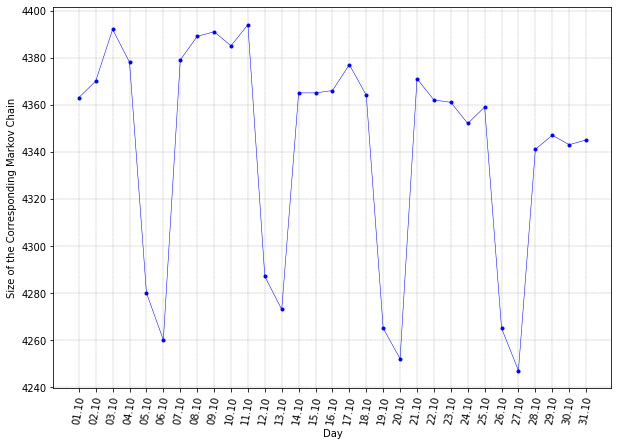

In [19]:
# Plot size
fig = plt.figure(figsize=(10, 7));
plt.plot(sizes, '.-b', linewidth=.51)
font = {'size': 12}
plt.rc('font', **font)
plt.ylabel('Size of the Corresponding Markov Chain')
plt.xlabel('Day')
xticks=[s for s in strings]
plt.xticks(range(len(sizes)), xticks, rotation=80, horizontalalignment='center')

plt.grid(linewidth=.31, color='gray', linestyle='--')

#path = 'C:/Users/GAO/Desktop/ML/ETH/Paper/size.jpg'
#fig.savefig(path, dpi=300)

plt.show()
plt.close()

## Analysis

In [20]:
def Analyze(MC, verbose='on'):
    e1 = time.time()    
    w, vl, vr = eig(MC, left=True)
    
    w = np.real(w)
    vl = np.real(vl)
    
    idx = np.argsort(w)
    w = w[idx]
    vl = vl[:,idx]
    
    eigvec_1 = (vl[:,-1])/(vl[:,-1]).sum()
    eigvec_2 = (vl[:,-2])
    
    ind = np.around(w,decimals=8)!=1
    K = np.divide(1,(1-w[ind])).sum()
    if verbose == 'on':
        print('Analysis in {}'.format(time.time() - e1))

    return eigvec_1, eigvec_2, K

In [21]:
def drazin_inverse(A, tol=1e-4):
    """Compute the Drazin inverse of A.

    Parameters:
        A ((n,n) ndarray): An nxn matrix.

    Returns:
       ((n,n) ndarray) The Drazin inverse of A.
    """
    #Implement Algorithm 15.1
    n = A.shape[0]
    f = lambda x: abs(x) > tol
    g = lambda x: abs(x) <= tol
    Q1, S, k1 = scipy.linalg.schur(A, sort=f)
    Q2, T, k2 = scipy.linalg.schur(A, sort=g)
    U = np.hstack((S[:,:k1], T[:,:n-k1]))
    #Calculate U^-1 only once
    U_inv = LA.inv(U)
    V = U_inv@A@U
    Z = np.zeros((n,n))
    if k1 != 0:
        Z[:k1, :k1] = LA.inv(V[:k1, :k1])
    return U@Z@U_inv

In [22]:
def effective_resistance(A):
    """Compute the effective resistance for each node in a graph.

    Parameters:
        A ((n,n) ndarray): The adjacency matrix of an undirected graph.

    Returns:
        ((n,n) ndarray) The matrix where the ijth entry is the effective
        resistance from node i to node j.
    """
    n = A.shape[0]
    #Compute the Laplacian of A
    L = np.diag(np.sum(A, axis=0)) - A
    R = []
    #Iteravely find L~_j^D and compute the jth row of R
    for j in range(n):
        L_j = L.copy()
        temp = np.zeros(n)
        temp[j] = 1
        L_j[j] = temp
        L_D = drazin_inverse(L_j)
        R.append(list(np.diag(L_D)))

    R = np.array(R)
    #Make the diagonal entries zero
    R = R - np.diag(np.diag(R))
    return R

In [23]:
# Faster approximation using Power Iteration
# def simulate_markov(TM, verbose='on', thres=1e-6, cycles=1e4):
#     e1 = time.time()
#     np.random.seed(0)
#     states_n = TM.shape[0]
#     pi = np.ones(states_n)
#     pi1 = np.zeros(states_n)
#     pi = np.random.rand(states_n)
#     pi = pi / pi.sum()

#     n = norm(pi - pi1)
#     i = 0
#     diff = []
#     while n > thres and i < cycles:
#         pi1 = TM.T.dot(pi).copy()
#         n = norm(pi - pi1)
#         i += 1
#         diff.append(n)
#         pi = pi1.copy()
#     if verbose == 'on':
#         print("Iterating {} times in {}".format(i, time.time() - e1))

#     mixing_ = i

#     return pi1, mixing_

### Calibration on Toy Matrix

In [24]:
#Example from Kirkland
P = np.array([[0, 0, 0.1, 0.9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
               [0, 0, 0, 0, 0.1, 0.8, 0.1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
               [0.1, 0.9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
               [0, 0, 0, 0, 0.8, 0.1, 0.1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
               [0.9, 0.1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
               [0, 0, 0.9, 0.1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
               [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
               [0, 0, 0, 0, 0.5, 0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
               [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.5, 0.5, 0, 0, 0, 0],
               [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
               [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.1, 0.9, 0, 0],
               [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.1, 0.9],
               [0, 0, 0, 0, 0, 0, 0, 0, 0, 0.1, 0.1, 0.8, 0, 0, 0, 0],
               [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.9, 0.1],
               [0, 0, 0, 0, 0, 0, 0, 0, 0, 0.1, 0.8, 0.1, 0, 0, 0, 0],
               [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.9, 0.1, 0, 0]])

In [25]:
Q = drazin_inverse(np.identity(P.shape[0]) - P, tol=1e-4)

In [26]:
R = effective_resistance(P)

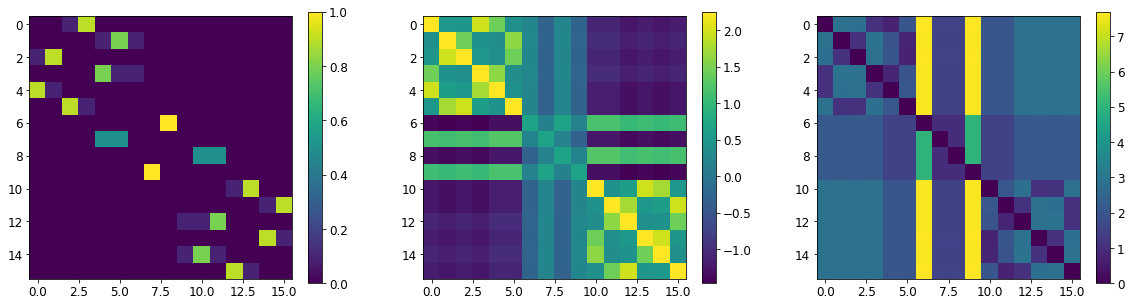

In [27]:
fig = plt.figure(figsize=(20, 5));
plt.subplot(131)
plt.imshow(P);
plt.colorbar()
plt.subplot(132)
plt.imshow(Q);
plt.colorbar()
plt.subplot(133)
plt.imshow(R);
plt.colorbar()
plt.show()
plt.close()

In [28]:
new = R*(P == 0)
minval = np.min(new[new > 0])
match = np.where(new==minval)

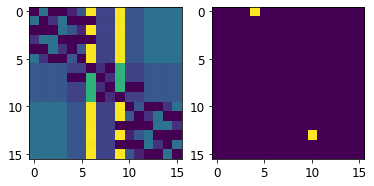

In [29]:
# Make friends
plt.subplot(121);
plt.imshow(new);
plt.subplot(122);
plt.imshow(new==minval);

In [30]:
AP = Analyze(P)

Analysis in 0.0033957958221435547


In [31]:
# Calculate Mean First Passage Time
MFPT = np.zeros(shape = P.shape)
for i, row in enumerate(Q):
    for j, value in enumerate(row):
        if j!=i:
            m = (Q[j][j] - Q[i][j]) / AP[0][j]
            MFPT[i][j] = m

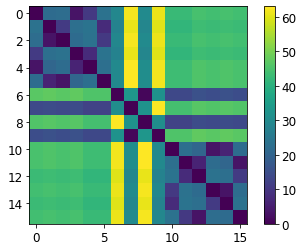

In [32]:
plt.imshow(MFPT);
plt.colorbar();

In [33]:
Ks = []
for i in range(0,len(Q)):
    K = 0
    for j, m in enumerate(MFPT[i]):
        K += m * AP[0][j]
    Ks.append(K)

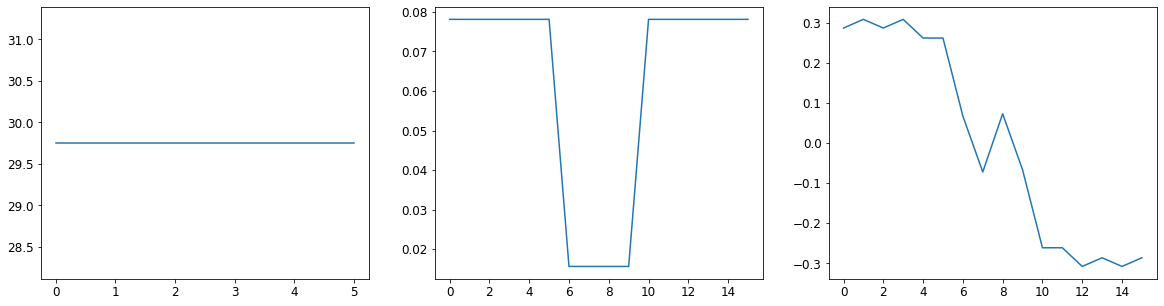

In [34]:
fig = plt.figure(figsize=(20, 5));
# Kemeny constant
plt.subplot(131);
plt.plot(Ks[:6]);
# First Eigenvector of P
plt.subplot(132);
plt.plot(AP[0]);
# Second Eigenvector of P
plt.subplot(133);
plt.plot(AP[1]);

In [35]:
# Kemeny Constant of P
print(AP[2])

31.13689729930268


### Compute Eigenvectors

In [ ]:
# ATMs = []
# sign = []
# 
# for TM in TMs:
#     ATM = Analyze(TM.values, verbose='on')
#     ATMs.append(ATM)    
#     sign.append(ATM[0].min()>0)

In [ ]:
# with open('ATMs.pkl', 'wb') as f:
#     pickle.dump(ATMs, f)

In [586]:
with open('ATMs.pkl', 'rb') as f:
    ATMs = pickle.load(f)

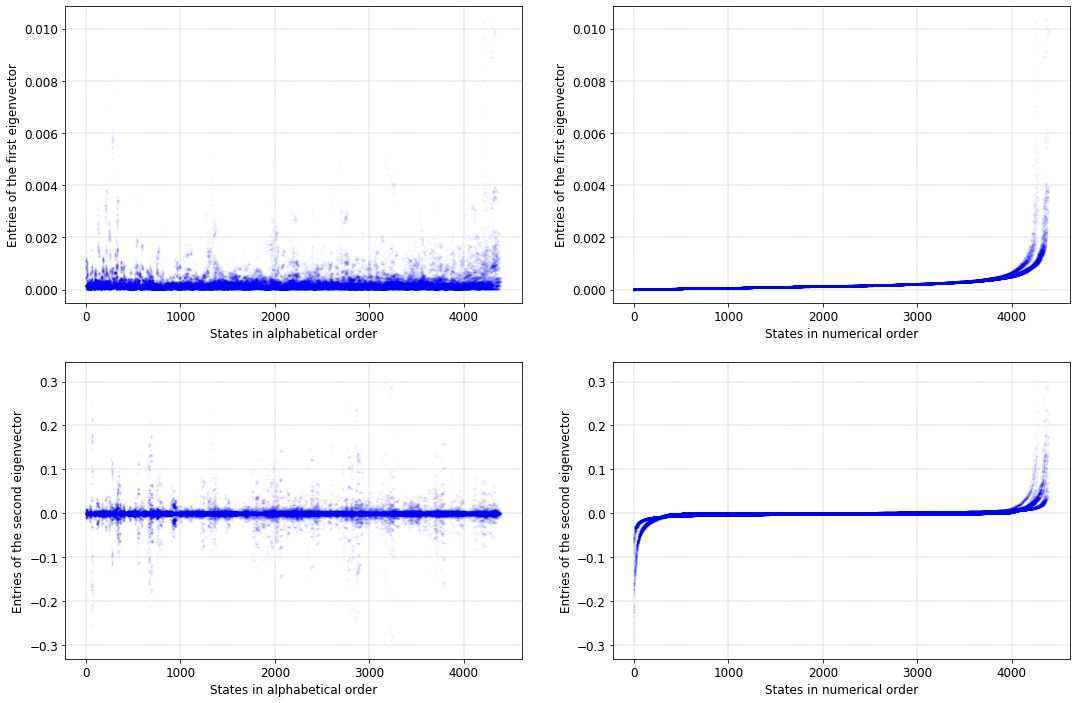

In [587]:
fig = plt.figure(figsize=(18, 12));
font = {'size': 12}
plt.rc('font', **font)
plt.subplot(221)
alpha = 0.025
markersize = 2.5
marker = '.'
linewidth= 0.31

plt.subplot(221)
plt.grid(linewidth=linewidth, color='gray', linestyle='--')
plt.ylabel('Entries of the first eigenvector')
plt.xlabel('States in alphabetical order')
for i in range(len(ATMs)):
    plt.plot((ATMs[i][0]), marker, color='b',alpha=alpha, markersize=markersize);
plt.subplot(222)
plt.ylabel('Entries of the first eigenvector')
plt.xlabel('States in numerical order')
plt.grid(linewidth=linewidth, color='gray', linestyle='--')
for i in range(len(ATMs)):
    plt.plot(np.sort(ATMs[i][0]), marker, color='b', alpha=alpha, markersize=markersize);
plt.subplot(223)
plt.ylabel('Entries of the second eigenvector')
plt.xlabel('States in alphabetical order')
plt.grid(linewidth=linewidth, color='gray', linestyle='--')
for i in range(len(ATMs)):
    plt.plot((ATMs[i][1]), marker, color='b', alpha=alpha, markersize=markersize);
plt.subplot(224)
plt.ylabel('Entries of the second eigenvector')
plt.xlabel('States in numerical order')
plt.grid(linewidth=linewidth, color='gray', linestyle='--')
for i in range(len(ATMs)):
    plt.plot(np.sort(ATMs[i][1]), marker, color='b', alpha=alpha, markersize=markersize);

path = '/home/georg/Jupyter/images/Eigenvectors.jpg'
fig.savefig(path, dpi=300, bbox_inches='tight')

plt.show()
plt.close()

### Common indices

In [38]:
# with open("blacklist.txt", "w") as f:
#     for s in blacklist:
#         f.write(str(s) +"\n")

In [39]:
blacklist = []
with open("blacklist.txt", "r") as f:
    for line in f:
        blacklist.append(line.strip())

In [40]:
print(blacklist)

['Aigle-Hôpital', 'Arosa', 'Balsthal', 'Basel Bad Bf', 'Basel St. Johann', 'Boden', 'Boll-Utzigen', 'Boncourt', 'Boudry', 'Broc-Fabrique', 'Buttes', 'Büren an der Aare', 'Cantello-Gaggiolo', 'Champ-du-Moulin', 'Champéry', 'Chemex', 'Châtel-St-Denis', 'Colmegna', 'Corcelles-Peseux', 'Couvet', 'Croix-du-Nant', 'Einsiedeln', 'En Charnet', 'Engelberg', 'Fayot', 'Flamatt Dorf', 'Genève-Aéroport', 'Gorgier-St-Aubin', 'Hinwil', 'La Cour', 'La Tour-de-Trême Parqueterie', 'La Verrerie', 'Lancy-Pont-Rouge', 'Laufenburg', 'Laupen', 'Lenk im Simmental', 'Les Arnoux', 'Les Deurres', 'Les Marches', 'Les Neys', 'Linthal', 'Linthal Braunwaldbahn', 'Lonay-Préverenges', 'Matten', 'Meyrin', 'Monthey-Ville', 'Nesslau-Neu St. Johann', 'Niederweningen', 'Niederweningen Dorf', 'Pont de Fayot', 'Pont du Rhône', 'Preglia', 'Ranzo-S. Abbondio', 'Route de Morgins', 'Schwarzenburg', 'St-Gingolph', 'St. Stephan', 'Stabio', 'Stettlen', 'Stöckli', 'Sumiswald-Grünen', 'Troistorrents', 'Unterzollikofen', "Val-d'Illiez

In [571]:
initial_states = []
for i, vector in enumerate(Vs):
    _vector = vector.copy(deep=True)    
    _vector['Date'] = str(datetime(year=2019, month=10, day=int(i + 1)))
    _vector['Flag'] = ~_vector['station'].str.contains('=>')
    _vector = _vector[_vector['Flag']]
    initial_states.append(_vector)

In [572]:
selected_states = []
for state in initial_states:
    state = state[state['Flag']]
    state.set_index('station', inplace=True)
    selected_states.append(state)

In [573]:
# Merge stations over whole month
merge = pd.concat(selected_states, axis=1, join='inner')

In [574]:
# Get common indices
common_indices = merge.index.values
len(common_indices)

1194

In [575]:
# Cleanup
indices = [x for x in common_indices if x not in blacklist]
len(indices)

1128

In [576]:
commonloc = locations.copy(deep=True)
commonloc = commonloc[commonloc['HALTESTELLEN_NAME'].isin(indices)]
commonloc.sort_values('HALTESTELLEN_NAME', inplace=True)
commonloc.set_index('HALTESTELLEN_NAME', inplace=True)

In [577]:
# First eigenvector of common stations
common_states = []
for i, vector in enumerate(Vs):
    _vector = vector.copy(deep=True)
    _vector['color'] = ATMs[i][0]
    _vector['Date'] = str(datetime(year=2019, month=10, day=int(i + 1)))
    _vector['Flag'] = _vector['station'].isin(indices)
    _vector = _vector[_vector['Flag']]   
    _vector.set_index('station', inplace=True)
    _vector.loc[:, 'lon'] = commonloc.geopos.map(lambda x: x[0])
    _vector.loc[:, 'lat'] = commonloc.geopos.map(lambda x: x[1])
    common_states.append(_vector)

In [578]:
# Compute pagerank
stationranks = []

for common in common_states:
    stationrank = common.sort_values(['color'], ascending=False)
    stationrank = stationrank.reset_index()
    stationranks.append(stationrank)

In [579]:
# Stationrank
@interact
def rank(day=(0, len(stationranks) - 1)):
    return stationranks[day]

interactive(children=(IntSlider(value=15, description='day', max=30), Output()), _dom_classes=('widget-interac…

In [580]:
@interact
def scatter(day=(0, len(stationranks) - 1)):
    cmap = cm.get_cmap('Spectral_r')
    fig, ax = plt.subplots(figsize=(5.5,5))
    stationranks[day].plot.scatter(x='outflow', y='color', s=5, c='origin', cmap=cmap, ax=ax)

interactive(children=(IntSlider(value=15, description='day', max=30), Output()), _dom_classes=('widget-interac…

In [581]:
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

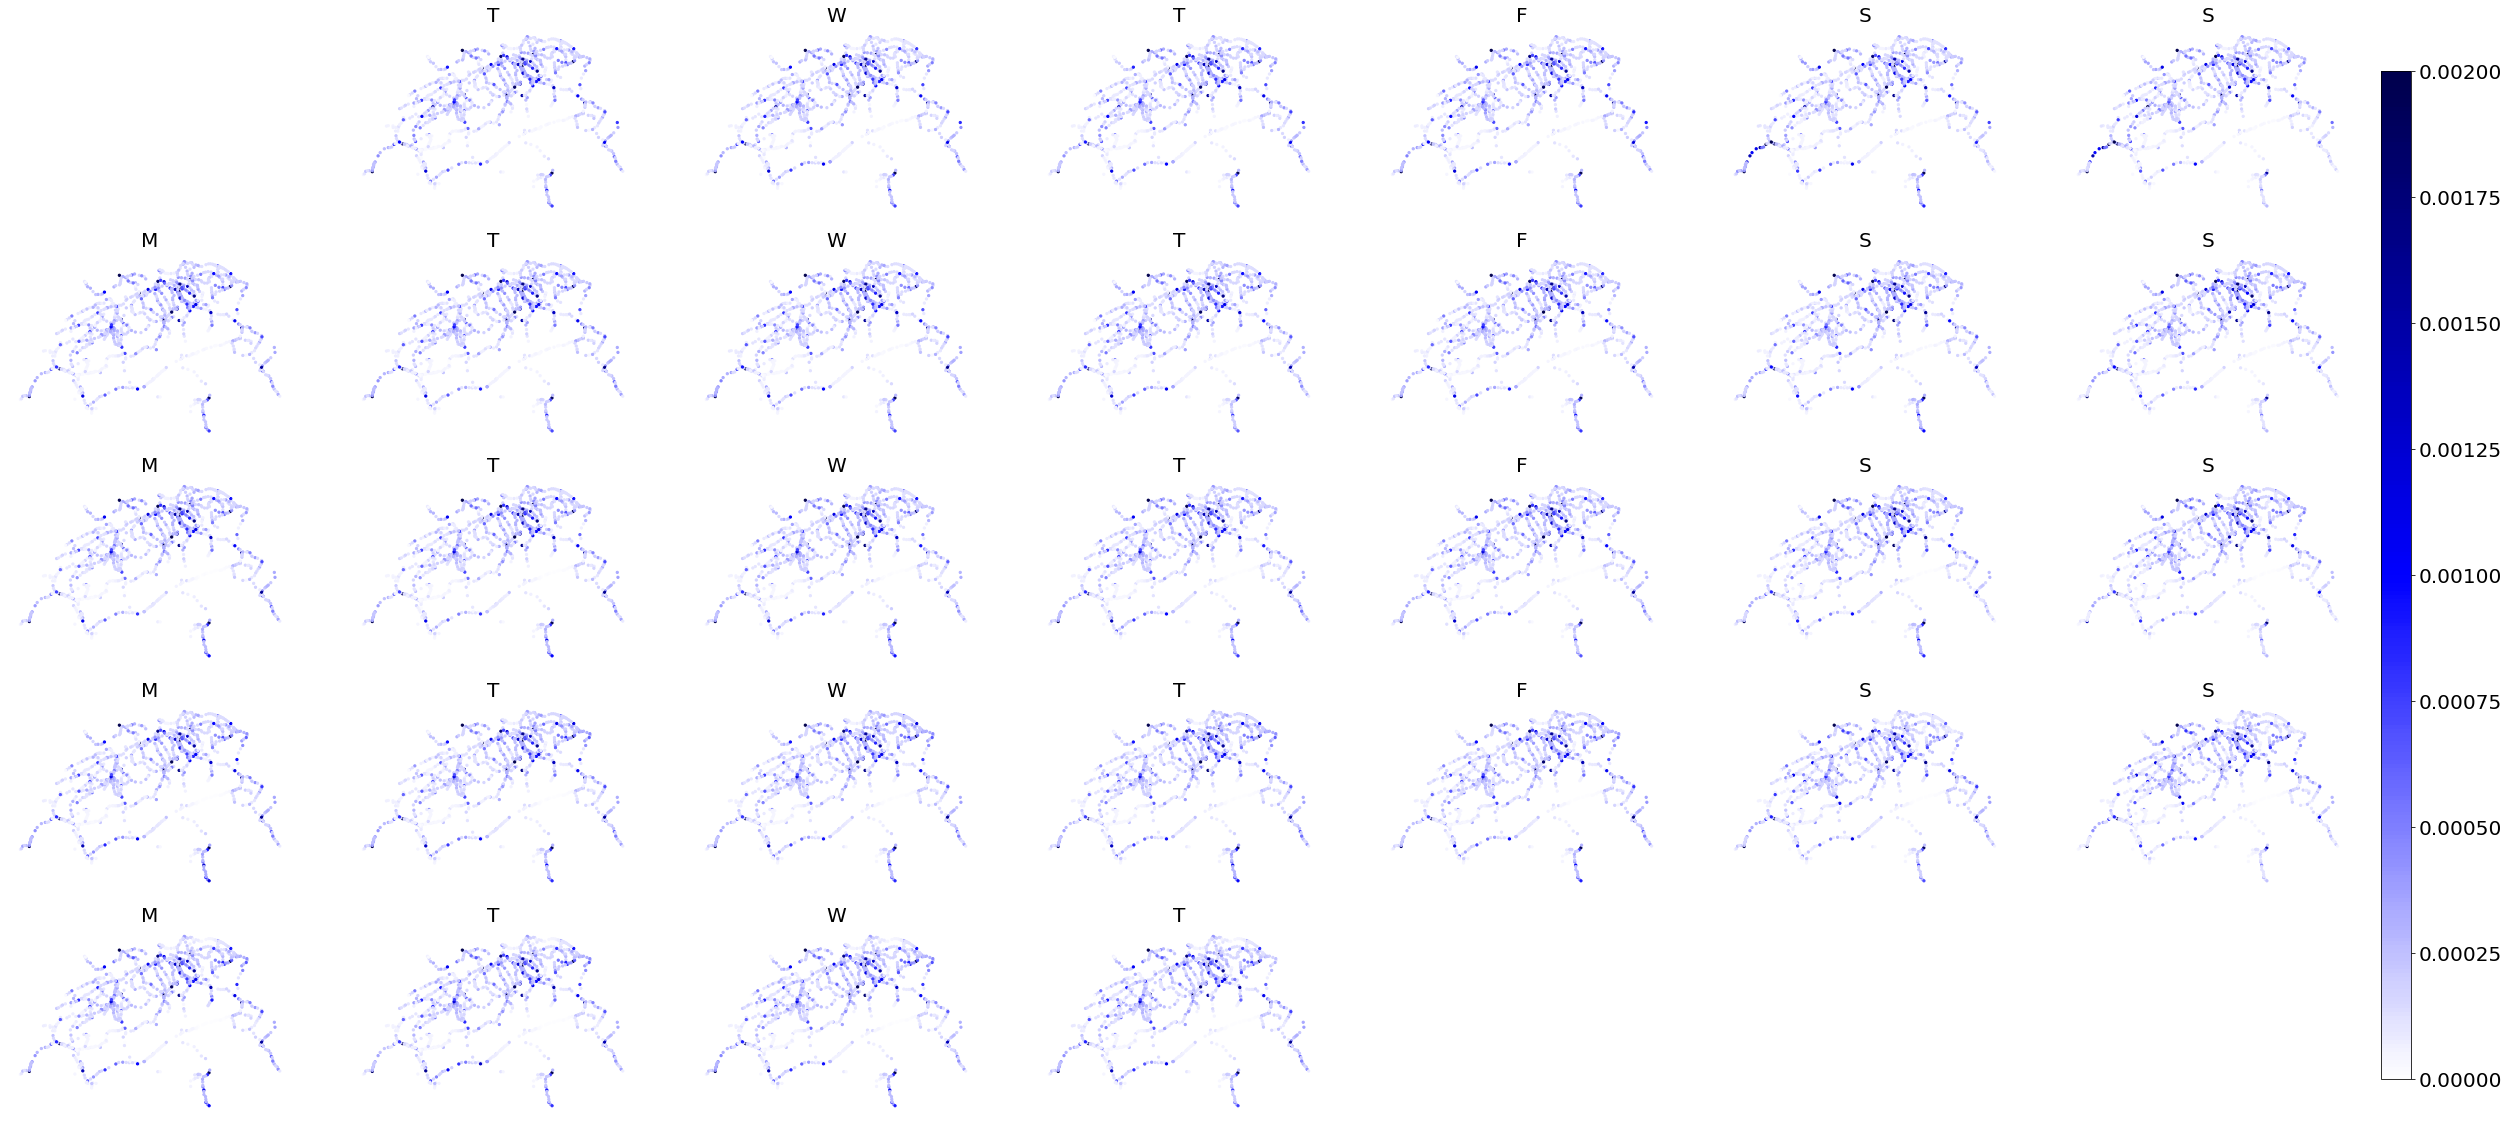

In [583]:
msz10 = 5
msz11 = 7

limit = 0.002

week = ['M', 'T', 'W', 'T', 'F', 'S', 'S']

cmap = plt.get_cmap('seismic_r')
new_cmap = truncate_colormap(cmap, 0.5, 1.0)

fontsize = 20
aspect = plt.rcParams['figure.figsize']
fig = plt.figure(figsize=(aspect[0]*msz11, aspect[1]*msz10))
for i in range(2, len(common_states)+2):
    
    plt.subplot(msz10, msz11, i)
    d = i-2
    x = common_states[d].lon.values
    y = common_states[d].lat.values
    c = common_states[d].color
    
    im = plt.scatter(
        x,
        y,
        c=c,
        norm=mpl.colors.Normalize(vmin=0,vmax=limit),
        s=5.0,
        cmap=new_cmap,
        alpha=1.0)
    
    plt.axis('off')
    plt.title(week[(i-1)%7], fontsize=fontsize)

cbar_ax = fig.add_axes([0.91, 0.15, 0.01, 0.7])
cbar_ax.tick_params(labelsize=fontsize) 
fig.colorbar(im, cbar_ax)

path = '/home/georg/Jupyter/images/Perron.jpg'
fig.savefig(path, dpi=300, bbox_inches='tight')

plt.show()
plt.close()

In [584]:
# Second eigenvector of common stations
common_states = []
for i, vector in enumerate(Vs):
    _vector = vector.copy(deep=True)
    _vector['color'] = ATMs[i][1]
    _vector['Date'] = str(datetime(year=2019, month=10, day=int(i + 1)))
    _vector['Flag'] = _vector['station'].isin(indices)
    _vector = _vector[_vector['Flag']]   
    _vector.set_index('station', inplace=True)
    _vector.loc[:, 'lon'] = commonloc.geopos.map(lambda x: x[0])
    _vector.loc[:, 'lat'] = commonloc.geopos.map(lambda x: x[1])
    if i in range(2,6) or i in range(9,13) or i in range(16,20):
        common_states.append(_vector)

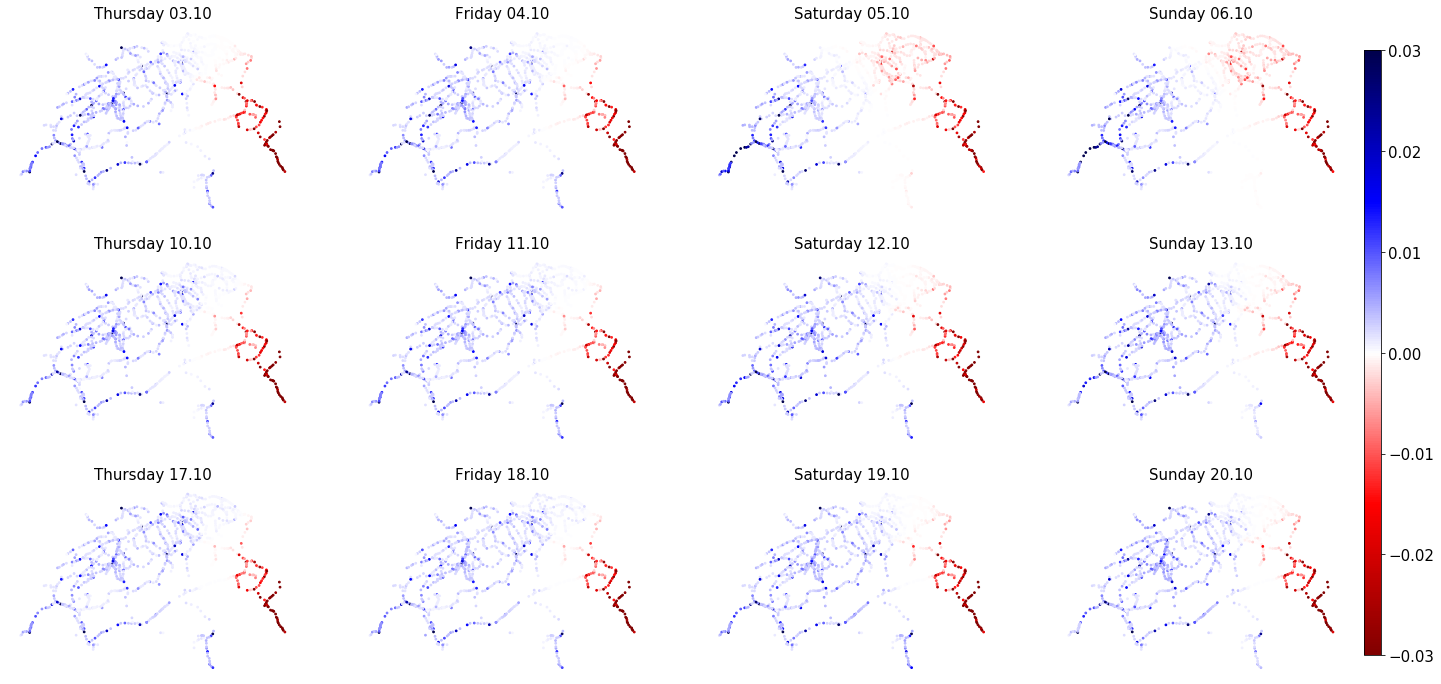

In [585]:
msz10 = 3
msz11 = 4
period = 4

limit = 0.03

week1 = ['Thursday 03.10', 'Friday 04.10', 'Saturday 05.10', 'Sunday 06.10']
week2 = ['Thursday 10.10', 'Friday 11.10', 'Saturday 12.10', 'Sunday 13.10']
week3 = ['Thursday 17.10', 'Friday 18.10', 'Saturday 19.10', 'Sunday 20.10']

fontsize = 15
aspect = plt.rcParams['figure.figsize']
fig = plt.figure(figsize=(aspect[0]*msz11, aspect[1]*msz10))
for i in range(1, len(common_states)+1):
    plt.subplot(msz10, msz11, i)
    d = i-1
    x = common_states[d].lon.values
    y = common_states[d].lat.values
    c = common_states[d].color
    
    if i in [1, 5, 10, 11]:
        cmap = plt.cm.seismic
    else:
        cmap = plt.cm.seismic_r
    im = plt.scatter(
        x,
        y,
        c=c,
        norm=mpl.colors.Normalize(vmin=-limit,vmax=limit),
        s=3.0,
        cmap = cmap,
        alpha=1.0)
    facecolor = 'white'
    fig.patch.set_facecolor(facecolor)
    plt.axis('off')
    if i<5:
        plt.title(week1[(i-1)%4], fontsize=fontsize)
    elif i <9:
        plt.title(week2[(i-1)%4], fontsize=fontsize)
    else:
        plt.title(week3[(i-1)%4], fontsize=fontsize)
        
cbar_ax = fig.add_axes([0.91, 0.15, 0.01, 0.7])
cbar_ax.tick_params(labelsize=fontsize) 
fig.colorbar(im, cbar_ax)
        
path = '/home/georg/Jupyter/images/Herbstferien.jpg'
fig.savefig(path, dpi=300, bbox_inches='tight')

plt.show()
plt.close()

In [55]:
Kemenys = []
for i in range(len(ATMs)):
    Kemenys.append(ATMs[i][2])

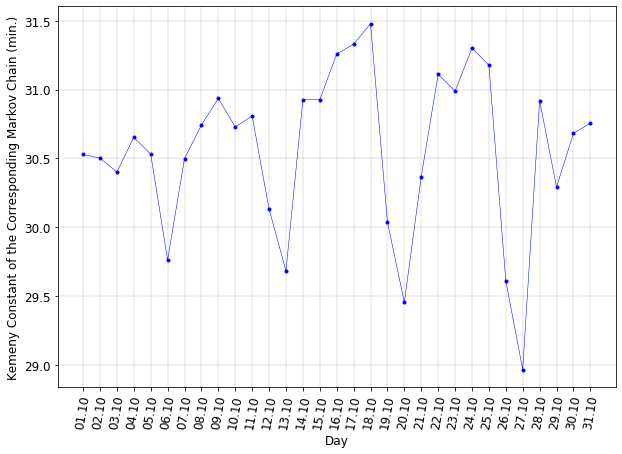

In [56]:
# Plot Kemeny constant
fig = plt.figure(figsize=(10, 7));
# It makes sense to divide over the sampling period
plt.plot(np.divide(Kemenys,1440), '.-b', linewidth=.51)
font = {'size': 12}
plt.rc('font', **font)
plt.ylabel('Kemeny Constant of the Corresponding Markov Chain (min.)')
plt.xlabel('Day')
xticks=[s for s in strings]
plt.xticks(range(len(sizes)), xticks, rotation=80, horizontalalignment='center')

plt.grid(linewidth=.31, color='gray', linestyle='--')

#path = 'C:/Users/GAO/Desktop/ML/ETH/Paper/size.jpg'
#fig.savefig(path, dpi=300)

plt.show()
plt.close()

## Sensitivity analysis of Markov chains

In [57]:
# Simultaneous Perturbation on incoming edges
def perturb(M, i, p):

    MC = M.copy()
    n = MC.shape[0]
    
    ei = np.zeros(shape=[n, 1])
    ei[i][0] = 1

    ep = np.zeros(shape=[n, 1])
    subtotal = 0
    for r in p:
        subtotal += MC[i][r]
    for r in p:
        ep[r][0] = MC[i][r] / subtotal
        
    fraction = subtotal / (1 - subtotal)

    if subtotal < 1:
        P = fraction * np.dot(ei, (np.dot(ei.T, MC) - ep.T))
    elif len(p)==1 and subtotal == 1:
        MC[i][p[0]] = -1
        MC[i][i] = 1
        P = MC
    return P

### Validation on Toy Matrix

In [58]:
# Modified Example from Kirkland
E = np.array([[0, 0, 0.1, 0.9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
               [0, 0, 0, 0, 0.1, 0.5, 0.1, 0.3, 0, 0, 0, 0, 0, 0, 0, 0],
               [0.1, 0.9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
               [0, 0, 0, 0, 0.8, 0.1, 0.1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
               [0.9, 0.1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
               [0, 0, 0.9, 0.1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
               [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
               [0, 0, 0, 0, 0.5, 0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
               [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.5, 0.5, 0, 0, 0, 0],
               [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
               [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.1, 0.9, 0, 0],
               [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.1, 0.9],
               [0, 0, 0, 0, 0, 0, 0, 0, 0, 0.1, 0.1, 0.8, 0, 0, 0, 0],
               [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.9, 0.1],
               [0, 0, 0, 0, 0, 0, 0, 0, 0, 0.1, 0.8, 0.1, 0, 0, 0, 0],
               [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.9, 0.1, 0, 0]])

In [59]:
print(perturb(E, 1, [5,6])[1])

[ 0.    0.    0.    0.    0.15 -0.5  -0.1   0.45  0.    0.    0.    0.
  0.    0.    0.    0.  ]


### Compute Perturbation on the Data

In [61]:
def sort_and_group(itr, f):
    return groupby(sorted(itr, key=f), f)

In [62]:
percent = -95

In [63]:
folder = 'Results'

In [505]:
# perturbers = ['Bern']
perturbers = list(indices)

# P corresponds to Perron eigenvector
# K corresponds to Kemeny constant

for d in range(3, 6):
    TM = TMs[d].values  
    N = TMs[d].shape[0]  
    perturbed = TMs[d].index
    
    P_normal = ATMs[d][0]
    K_normal = ATMs[d][2]

    P_perturbed = []
    P_diff = []
    K_diff = []

    for station in tqdm(perturbers):
        p = np.where(perturbed == station)[0][0]
        
        # States directly connected with target
        inbound = list(np.asarray(np.where(TM[:,p] > 0))[0])
        if p in inbound:
            inbound.remove(p)
        
        # States indirectly connected with target
        incoming = []
        # Singular terminals
        rogue = []
        
        # Search and exclude singular terminals among the inbound states
        for i in inbound:
            roel = list(np.asarray(np.where(TM[i,:] > 0))[0])
            if len(roel)>1000:
                rogue.append(i)
                inbound.remove(i)            
            gc.collect()
                
        # Search for the incoming
        for n, i in enumerate(inbound):
            coel = list(np.asarray(np.where(TM[:,i] > 0))[0])
            if i in coel:
                coel.remove(i)
            coel = [e for e in coel if e not in rogue]
            # Special case where inbound coincides with target and incoming with inbound
            if len(coel)>1:
                inbound[n] = p
                coel = [i]
            incoming.append(coel[0])            
            gc.collect()
        
        # Match incoming to a list of inbounds
        dictionary = dict(zip(inbound, incoming))
        reversed_dict = {number: [char for char,_ in v] 
                         for number, v in sort_and_group(dictionary.items(), itemgetter(1))}
        del dictionary
        gc.collect()
        # Reserved for debugging
        debug = False
        if debug:
            for k, v in reversed_dict.items():
                print(perturbed[k], list(perturbed[v]))

        # Perturbation factor  
        t =  -percent / 100
      
        # Perturbation of Transition Matrix
        PM = np.zeros(shape=[N, N])
        for k, v in reversed_dict.items():
            PM += t*perturb(TM, k, v)
        PM += TM
        
        del reversed_dict
        gc.collect()
      
        # Analytic calculation on Perturbed Matrix
        APM = Analyze(PM, verbose='off')
        P = APM[0]
        K = APM[2]
        PDF = 100 * (P - P_normal) / P_normal
        KDF = 100 * (K - K_normal)/ K_normal
        
        del PM, APM
        gc.collect()
        
        P_perturbed.append(P)
        P_diff.append(PDF)
        K_diff.append(KDF)
      
    # Save to file
    save = True
    if save:  
        # P_normal
        DF = pd.DataFrame(
            index=['P_normal'], data=np.asarray(P_normal)[np.newaxis,:], columns=perturbed)
        path = 'data/istdaten/{}/perturbations/{}/P_normal_{}_{:>02}{}2019.pkl'.format(
            month, folder, str(percent), str(d + 1), imonth)
        DF.to_pickle(path)        

        # P_perturbed
        DF = pd.DataFrame(
            index=perturbers, data=np.asarray(P_perturbed), columns=perturbed)
        path = 'data/istdaten/{}/perturbations/{}/P_perturbed_{}_{:>02}{}2019.pkl'.format(
            month, folder, str(percent), str(d + 1), imonth)
        DF.to_pickle(path)

        # P_diff
        DF = pd.DataFrame(
            index=perturbers, data=np.asarray(P_diff), columns=perturbed)
        path = 'data/istdaten/{}/perturbations/{}/P_diff_{}_{:>02}{}2019.pkl'.format(
            month, folder, str(percent), str(d + 1), imonth)
        DF.to_pickle(path)

        # K_diff
        DF = pd.DataFrame(
            index=perturbers, data=np.asarray(K_diff), columns=['Kemeny_Change_PCT'])
        path = 'data/istdaten/{}/perturbations/{}/K_diff_{}_{:>02}{}2019.pkl'.format(
            month, folder, str(percent), str(d + 1), imonth)
        DF.to_pickle(path)
        
        # Free memory
        del DF
        gc.collect()
        DF=pd.DataFrame()      

### Perturbed Data

In [556]:
d = 4

In [557]:
pi_normal_path = 'data/istdaten/{}/perturbations/{}/P_normal_{}_{:>02}{}2019.pkl'.format(
            month, folder, str(percent), str(d + 1), imonth)
pi_normal = pd.read_pickle(pi_normal_path)
# pi_normal = pi_normal[list(indices)]

pi_perturbed_path = 'data/istdaten/{}/perturbations/{}/P_perturbed_{}_{:>02}{}2019.pkl'.format(
            month, folder, str(percent), str(d + 1), imonth)
pi_perturbed = pd.read_pickle(pi_perturbed_path)
# pi_perturbed = pi_perturbed[list(indices)]

pi_diff_path = 'data/istdaten/{}/perturbations/{}/P_diff_{}_{:>02}{}2019.pkl'.format(
            month, folder, str(percent), str(d + 1), imonth)
pi_diff = pd.read_pickle(pi_diff_path)
# pi_diff = pi_diff[list(indices)]

In [558]:
target = list(pi_diff.index).index('Genève')

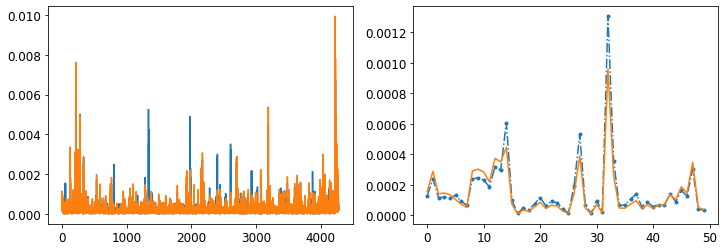

In [559]:
fig = plt.figure(figsize=(12, 4));
font = {'size': 12}
plt.rc('font', **font)
plt.subplot(121)
# First Eigenvector of TM
plt.plot(ATMs[d][0]);
plt.plot(pi_perturbed.values[target]);
plt.subplot(122)
# Detail
lower = 2250
upper = 2300
plt.plot(ATMs[d][0][lower:upper], '.-.');
plt.plot(pi_perturbed.values[target][lower:upper]);

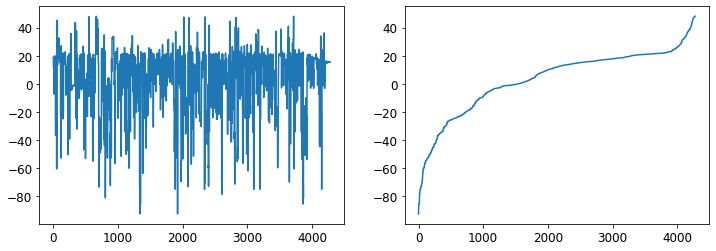

In [560]:
fig = plt.figure(figsize=(12, 4));
font = {'size': 12}
plt.rc('font', **font)
plt.subplot(121)
plt.plot(pi_diff.values[target]);
plt.subplot(122)
plt.plot(np.sort(pi_diff.values[target]));

In [561]:
# Pi difference of common stations
common_states = []
shift = 0
for i, vector in enumerate(Vs[shift:6]):
    pi_diff_path = 'data/istdaten/{}/perturbations/{}/P_diff_{}_{:>02}{}2019.pkl'.format(
    month, folder, (percent), str(i + 1 + shift), imonth)
    pi_diff = pd.read_pickle(pi_diff_path)
    _vector = vector.copy(deep=True)
    _vector['color'] = pi_diff.values[target]
    _vector['Date'] = str(datetime(year=2019, month=10, day=int(i + 1 + shift)))
    _vector['Flag'] = _vector['station'].isin(indices)
    _vector = _vector[_vector['Flag']]   
    _vector.set_index('station', inplace=True)
    _vector.loc[:, 'lon'] = commonloc.geopos.map(lambda x: x[0])
    _vector.loc[:, 'lat'] = commonloc.geopos.map(lambda x: x[1])
    common_states.append(_vector)

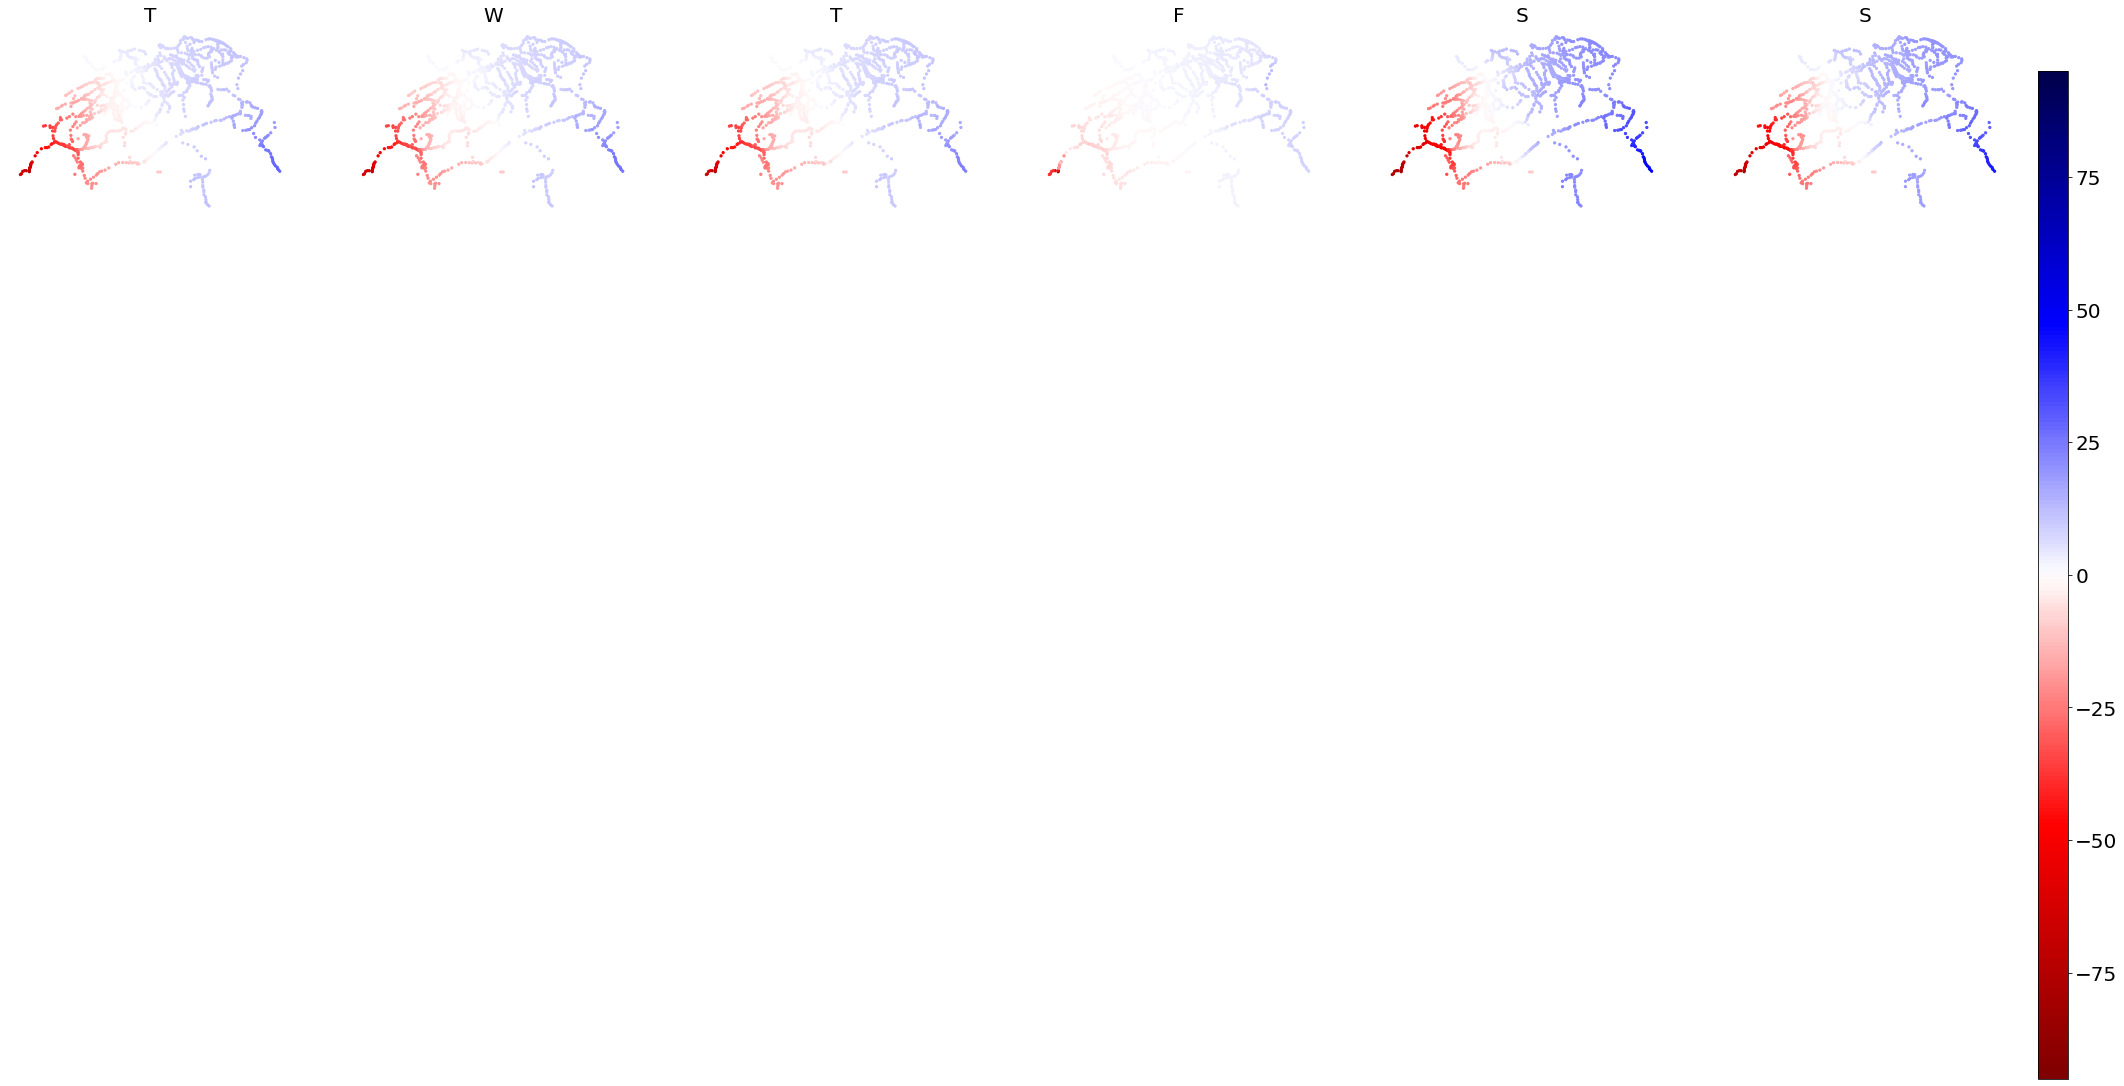

In [562]:
msz10 = 5
msz11 = 7

limit = 95

cmap = plt.get_cmap('seismic_r')
new_cmap = truncate_colormap(cmap, 0.0, 1.0)

fontsize = 20
aspect = plt.rcParams['figure.figsize']
fig = plt.figure(figsize=(aspect[0]*msz11, aspect[1]*msz10))
for i in range(2, len(common_states)+2):
    
    plt.subplot(msz10, msz11, i)
    d = i-2
    x = common_states[d].lon.values
    y = common_states[d].lat.values
    c = common_states[d].color
    
    im = plt.scatter(
        x,
        y,
        c=c,
        norm=mpl.colors.Normalize(vmin=-limit,vmax=limit),
        s=5.0,
        cmap=new_cmap,
        alpha=1.0)
    
    plt.axis('off')
    plt.title(week[(i-1)%7], fontsize=fontsize)

cbar_ax = fig.add_axes([0.91, 0.15, 0.01, 0.7])
cbar_ax.tick_params(labelsize=fontsize) 
fig.colorbar(im,cbar_ax);

### Effect on Kemeny Constant

In [564]:
# Kemeny difference
common_states = []
shift = 0
for i, vector in enumerate(Vs[shift:6]):
    K_diff_path = 'data/istdaten/{}/perturbations/{}/K_diff_{}_{:>02}{}2019.pkl'.format(
        month, folder, (percent), str(i + 1 + shift), imonth)
    K_diff = pd.read_pickle(K_diff_path)
    _vector = vector.copy(deep=True)
    _vector['Date'] = str(datetime(year=2019, month=10, day=int(i + 1 + shift)))
    _vector['Flag'] = _vector['station'].isin(indices)
    _vector = _vector[_vector['Flag']]   
    _vector['color'] = K_diff.values
    _vector.set_index('station', inplace=True)
    _vector.loc[:, 'lon'] = commonloc.geopos.map(lambda x: x[0])
    _vector.loc[:, 'lat'] = commonloc.geopos.map(lambda x: x[1])
    common_states.append(_vector)

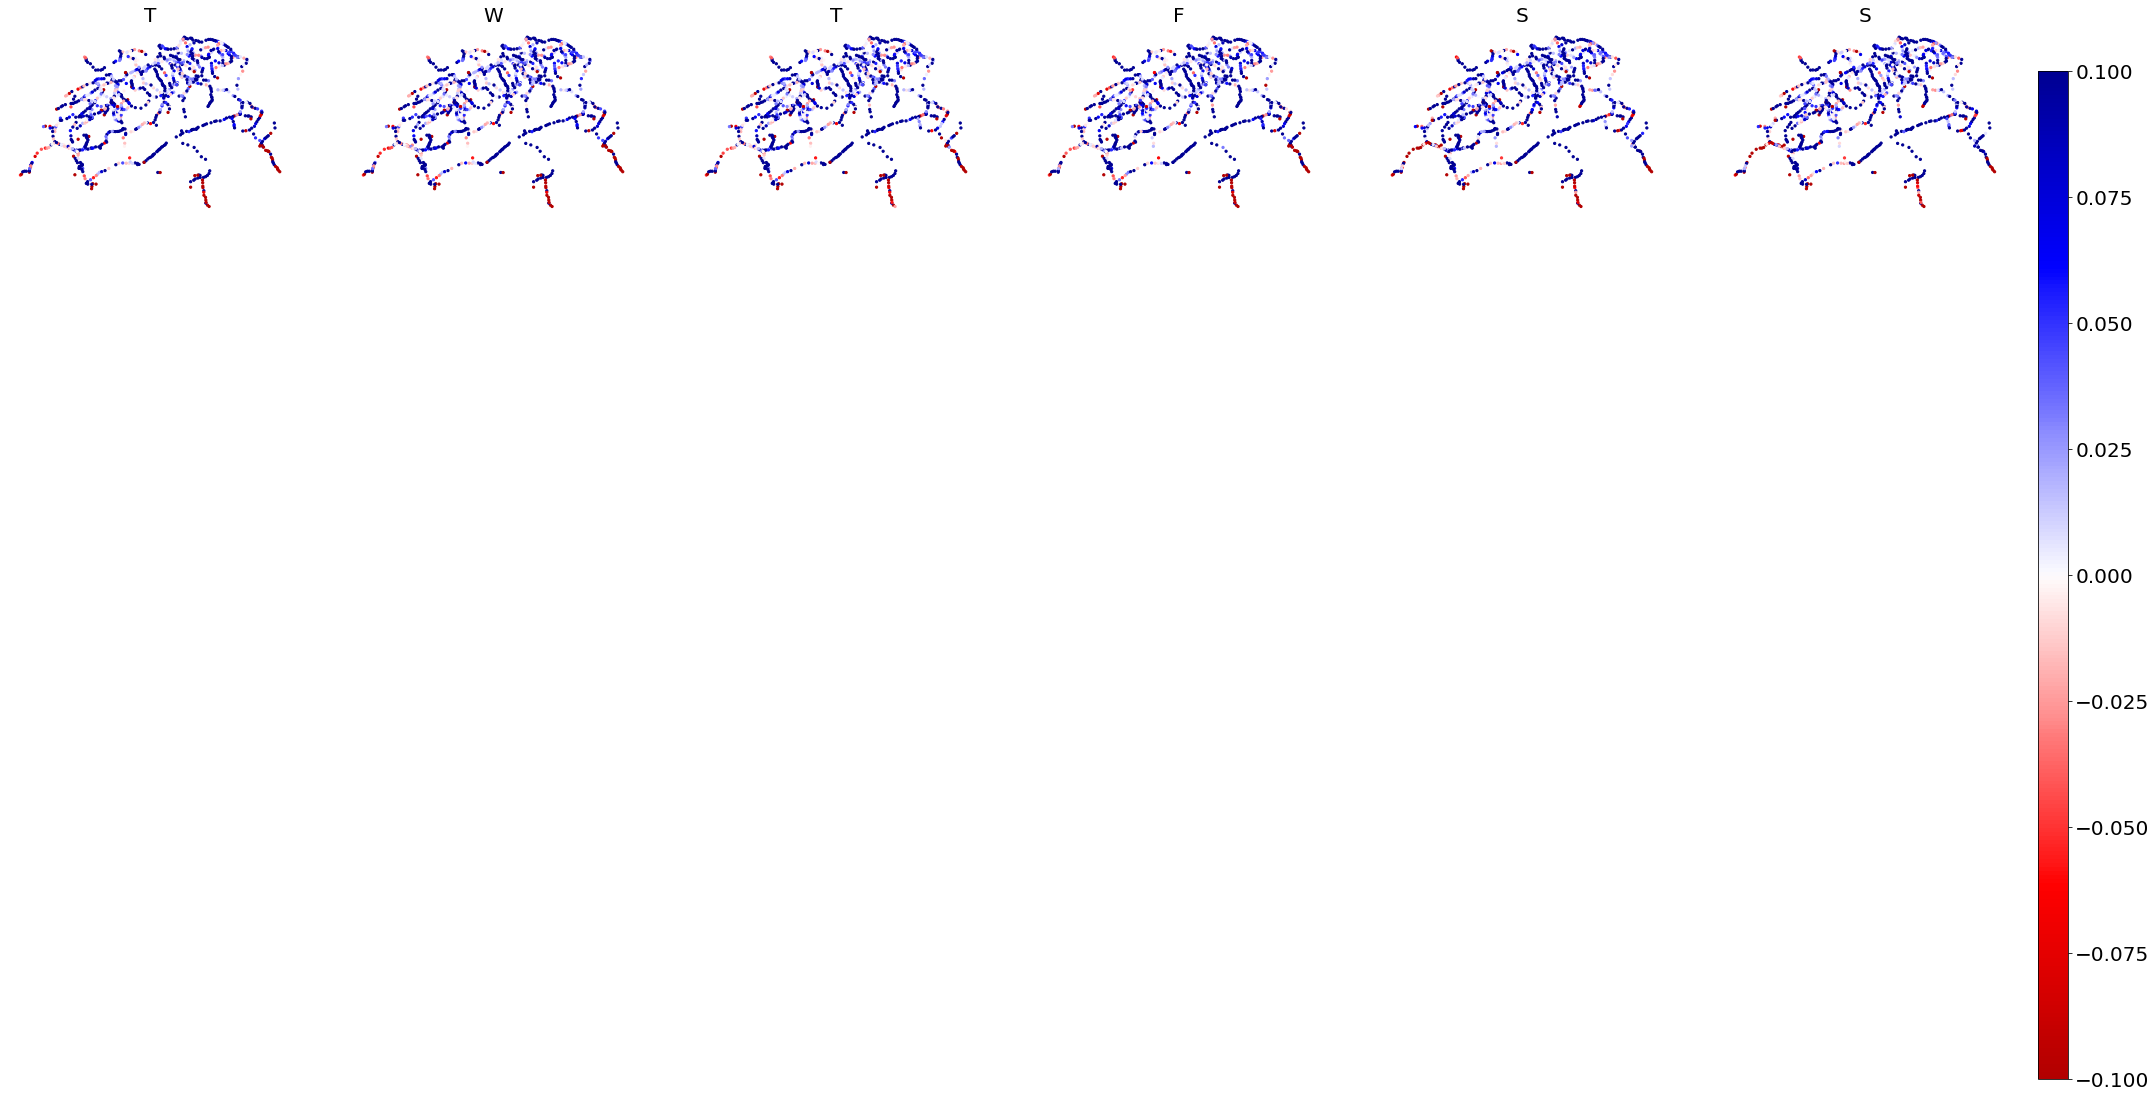

In [568]:
msz10 = 5
msz11 = 7

limit = 0.1

cmap = plt.get_cmap('seismic_r')
new_cmap = truncate_colormap(cmap, 0.1, 0.9)

fontsize = 20
aspect = plt.rcParams['figure.figsize']
fig = plt.figure(figsize=(aspect[0]*msz11, aspect[1]*msz10))
for i in range(2, len(common_states)+2):
    
    plt.subplot(msz10, msz11, i)
    d = i-2
    x = common_states[d].lon.values
    y = common_states[d].lat.values
    c = common_states[d].color
    
    im = plt.scatter(
        x,
        y,
        c=c,
        norm=mpl.colors.Normalize(vmin=-limit,vmax=limit),
        s=5,
        cmap=new_cmap,
        alpha=1.0)
    
    plt.axis('off')
    plt.title(week[(i-1)%7], fontsize=fontsize)

cbar_ax = fig.add_axes([0.91, 0.15, 0.01, 0.7])
cbar_ax.tick_params(labelsize=fontsize) 
fig.colorbar(im,cbar_ax);

## Calculating Systemic Influence, Systemic Fragility and other measures

In [544]:
d = 5

In [545]:
pi_normal_path = 'data/istdaten/{}/perturbations/{}/P_normal_{}_{:>02}{}2019.pkl'.format(
            month, folder, str(percent), str(d + 1), imonth)
pi_normal = pd.read_pickle(pi_normal_path)
pi_normal = pi_normal[list(indices)]

pi_perturbed_path = 'data/istdaten/{}/perturbations/{}/P_perturbed_{}_{:>02}{}2019.pkl'.format(
            month, folder, str(percent), str(d + 1), imonth)
pi_perturbed = pd.read_pickle(pi_perturbed_path)
pi_perturbed = pi_perturbed[list(indices)]

pi_diff_path = 'data/istdaten/{}/perturbations/{}/P_diff_{}_{:>02}{}2019.pkl'.format(
            month, folder, str(percent), str(d + 1), imonth)
pi_diff = pd.read_pickle(pi_diff_path)
pi_diff = pi_diff[list(indices)]

In [546]:
# Threshold of change in pct
thresh =1

dim = pi_diff.shape[1]

In [547]:
# Systemic Influence
no_of_pos_affecting = (pi_diff.values[:dim, :dim] > thresh).sum(axis=1)
no_of_neg_affecting = (pi_diff.values[:dim, :dim] < -1 * thresh).sum(axis=1)

ind_pos_affecting = pi_diff.values[:dim, :dim] > thresh
ind_neg_affecting = pi_diff.values[:dim, :dim] < -1 * thresh
pos_affecting = np.zeros(dim)
neg_affecting = np.zeros(dim)

for i in range(dim):
    pos_affecting[i] = pi_diff.values[i, ind_pos_affecting[i]].dot(
        pi_normal.values[0, :dim][ind_pos_affecting[i]])
    neg_affecting[i] = pi_diff.values[i, ind_neg_affecting[i]].dot(
        pi_normal.values[0, :dim][ind_neg_affecting[i]])
    
sum_of_affecting = np.abs(neg_affecting) + pos_affecting

#systemic_influence = (no_of_pos_affecting + no_of_neg_affecting) / float(dim)
systemic_influence = (sum_of_affecting) / float(sum_of_affecting.max())

In [548]:
# Systemic Fragility
no_of_pos_affected = (pi_diff.values[:dim, :dim] > thresh).sum(axis=0)
no_of_neg_affected = (pi_diff.values[:dim, :dim] < -1 * thresh).sum(axis=0)

ind_pos_affected = pi_diff.values[:dim, :dim] > thresh
ind_neg_affected = pi_diff.values[:dim, :dim] < -1 * thresh
pos_affected = np.zeros(dim)
neg_affected = np.zeros(dim)

for i in range(dim):
    pos_affected[i] = pi_diff.values[ind_pos_affected[:dim, i],
                                     i].sum() * pi_normal.values[0, i]
    neg_affected[i] = pi_diff.values[ind_neg_affected[:dim, i],
                                     i].sum() * pi_normal.values[0, i]

# We want to take out the effect each node on itself
self_change = np.diag(pi_diff.values[:, :dim]) * pi_normal.values[0, :dim]
sum_of_affected = np.abs(neg_affected) + pos_affected - np.abs(self_change)    
    
systemic_fragility = (no_of_pos_affected + no_of_neg_affected) / float((no_of_pos_affected + no_of_neg_affected).max())
#systemic_fragility = (sum_of_affected) / float(dim)

### Systemic fragility vs. systemic influence

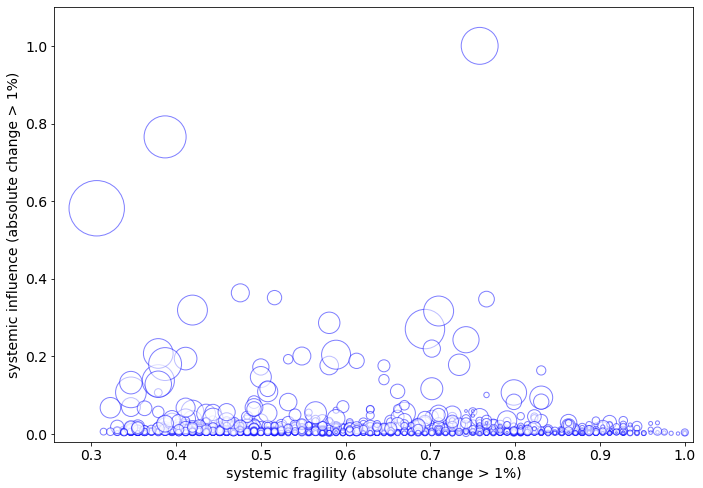

In [549]:
fig = plt.figure(figsize=(10, 7))
plt.subplot(1, 1, 1)
font = {'size': 12}
plt.rc('font', **font)

ax = plt.gca()

x = systemic_fragility
y = systemic_influence
z = pi_normal.values[0]

p = plt.scatter(
    x,
    y,
    c='white',
    s=z * pow(10, 5.5),
    marker='o',
    edgecolor='Blue',
    cmap=plt.cm.Blues_r,
    alpha=0.5)

plt.xlabel('systemic fragility (absolute change > {}%)'.format(thresh))
plt.ylabel('systemic influence (absolute change > {}%)'.format(thresh))

xmin = x.min() - 0.05
xmax = x.max() + 0.01

ymin = y.min() - 0.02
ymax = y.max() + 0.1

plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)

font = {'size': 14.}

plt.rc('font', **font)
plt.tight_layout()

path = '/home/georg/Jupyter/images/systemic_{:02d}.jpg'.format(int(d + 1))
fig.savefig(path, dpi=300)

plt.show();
plt.close();

### Systemic influence

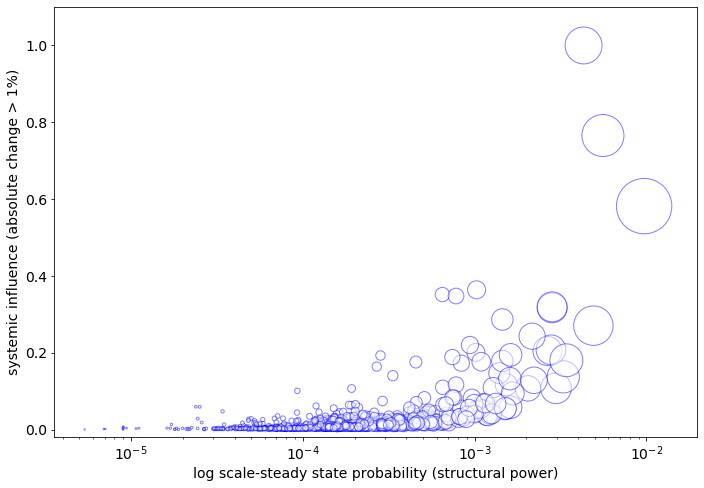

In [550]:
fig = plt.figure(figsize=(10, 7))
plt.subplot(1, 1, 1)
font = {'size': 12}
plt.rc('font', **font)

ax = plt.gca()
ax.set_xscale('log')
metric = systemic_influence
y = metric
x = pi_normal.values[0]
z = pi_normal.values[0]

p = plt.scatter(
    x,
    y,
    c='white',
    s=z * pow(10, 5.5),
    marker='o',
    edgecolor='Blue',
    cmap=plt.cm.Blues_r,
    alpha=0.5)

plt.ylabel('systemic influence (absolute change > {}%)'.format(thresh))
plt.xlabel('log scale-steady state probability (structural power)')

xmin = x.min() / 1.5
xmax = x.max() + 0.01

ymin = y.min() - 0.02
ymax = y.max() + 0.1

plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)

font = {'size': 14.}

plt.rc('font', **font)
plt.tight_layout()

path = '/home/georg/Jupyter/images/systemic_influence_{:02d}.jpg'.format(int(d + 1))
fig.savefig(path, dpi=300)
plt.show();
plt.close();

### Top 10 nodes with the highest systemic influence

In [551]:
dd = np.concatenate(
    (pi_normal.T.index.values[:][:, np.newaxis],
     pi_normal.T['P_normal'].values[:][:, np.newaxis],
     systemic_fragility[:, np.newaxis],
     systemic_influence[:, np.newaxis]),
    axis=1)

DF = pd.DataFrame(
    data=dd,
    columns=[
        'Names', 'structural power', 'Systemic Fragility', 'Systemic Influence'
    ])

DF.head()
DF = DF.sort_values(['Systemic Influence'], ascending=[False])
DF.index = range(1, DF.shape[0] + 1)
DF.loc[DF.index[:10]]

,Names,structural power,Systemic Fragility,Systemic Influence
1,Genève,0.00430876,0.758065,1
2,Bern,0.00558512,0.387097,0.765528
3,Zürich HB,0.00970307,0.306452,0.581654
4,Sargans,0.00102664,0.475806,0.363759
5,Fribourg/Freiburg,0.00064895,0.516129,0.351448
6,Yverdon-les-Bains,0.000779436,0.766129,0.347625
7,Winterthur,0.00282542,0.419355,0.319392
8,Morges,0.00282871,0.709677,0.316949
9,Arth-Goldau,0.00145084,0.580645,0.286577
10,Lausanne,0.00491394,0.693548,0.27045


### Top 10 nodes with the lowest systemic influence

In [552]:
dd = np.concatenate(
    (pi_normal.T.index.values[:][:, np.newaxis],
     pi_normal.T['P_normal'].values[:][:, np.newaxis],
     systemic_fragility[:, np.newaxis],
     systemic_influence[:, np.newaxis]),
    axis=1)

DF = pd.DataFrame(
    data=dd,
    columns=[
        'Names', 'structural power', 'Systemic Fragility', 'Systemic Influence'
    ])

DF.head()
DF = DF.sort_values(['Systemic Influence'], ascending=[True])
DF.index = range(1, DF.shape[0] + 1)
DF.loc[DF.index[:10]]

,Names,structural power,Systemic Fragility,Systemic Influence
1,Belmont-sur-Montreux,8.98115e-06,0.927419,6.61348e-05
2,Blausee-Mitholz,5.35802e-06,0.66129,0.00028269
3,Le Locle-Col-des-Roches,1.8858e-05,0.677419,0.000555798
4,Reichenburg,1.79559e-05,0.580645,0.000644378
5,Bilten,2.19281e-05,0.580645,0.000675077
6,Schübelbach-Buttikon,1.79743e-05,0.580645,0.000719231
7,Pino-Tronzano,2.66009e-05,0.83871,0.000744684
8,Faulensee,2.13764e-05,0.645161,0.000766486
9,Gerra (Gambarogno),2.66009e-05,0.830645,0.000898536
10,Grandgourt,3.07379e-05,0.516129,0.00109359


### Systemic fragility

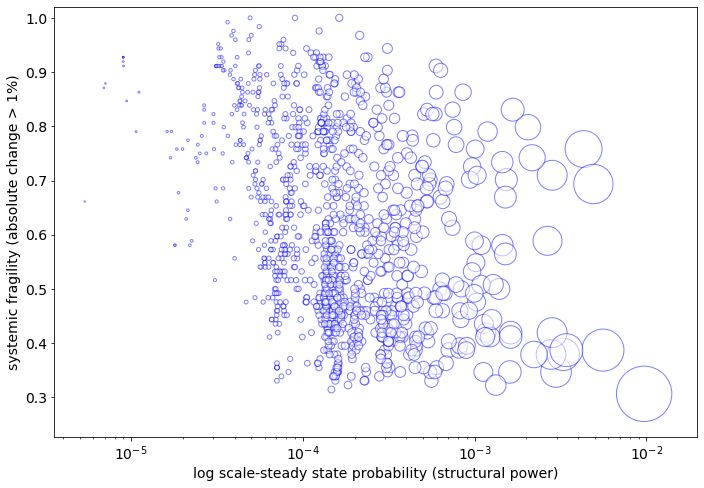

In [553]:
fig = plt.figure(figsize=(10, 7))
plt.subplot(1, 1, 1)

ax = plt.gca()
ax.set_xscale('log')
metric = systemic_fragility
y = metric
x = pi_normal.values[0]
z = pi_normal.values[0]

p = plt.scatter(
    x,
    y,
    c='white',
    s=z * pow(10, 5.5),
    marker='o',
    edgecolor='Blue',
    cmap=plt.cm.Blues_r,
    alpha=0.5)

plt.ylabel('systemic fragility (absolute change > {}%)'.format(thresh))
plt.xlabel('log scale-steady state probability (structural power)')

xmin = x.min() / 1.5
xmax = x.max() + 0.01

ymin = y.min() - 0.08
ymax = y.max() + 0.02

plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)

font = {'size': 14.}

plt.rc('font', **font)
plt.tight_layout()

path = '/home/georg/Jupyter/images/systemic_fragility_{:02d}.jpg'.format(int(d + 1))
fig.savefig(path, dpi=300)

plt.show();
plt.close();

### Top 10 nodes with the lowest systemic fragility

In [554]:
dd = np.concatenate(
    (pi_normal.T.index.values[:][:, np.newaxis],
     pi_normal.T['P_normal'].values[:][:, np.newaxis],
     systemic_fragility[:, np.newaxis],
     systemic_influence[:, np.newaxis]),
    axis=1)

DF = pd.DataFrame(
    data=dd,
    columns=[
        'Names', 'structural power', 'Systemic Fragility', 'Systemic Influence'
    ])

DF.head()
DF = DF.sort_values(['Systemic Fragility', 'structural power'], ascending=[True, True])
DF.index = range(1, DF.shape[0] + 1)
DF.loc[DF.index[:10]]

,Names,structural power,Systemic Fragility,Systemic Influence
1,Zürich HB,0.00970307,0.306452,0.581654
2,Däniken,0.000146469,0.314516,0.00627591
3,Schönenwerd SO,0.000183041,0.322581,0.00601103
4,Zürich Hardbrücke,0.00132751,0.322581,0.0678069
5,Diepflingen,7.05055e-05,0.330645,0.00273254
6,Basel Dreispitz,0.000154333,0.330645,0.00847035
7,Lausen,0.000227464,0.330645,0.00700308
8,Aarburg-Oftringen,0.000229259,0.330645,0.00820563
9,Liestal,0.000559928,0.330645,0.0186709
10,Dulliken,7.49489e-05,0.33871,0.00281551


### Top 10 nodes with the highest systemic fragility

In [555]:
dd = np.concatenate(
    (pi_normal.T.index.values[:][:, np.newaxis],
     pi_normal.T['P_normal'].values[:][:, np.newaxis],
     systemic_fragility[:, np.newaxis],
     systemic_influence[:, np.newaxis]),
    axis=1)

DF = pd.DataFrame(
    data=dd,
    columns=[
        'Names', 'structural power', 'Systemic Fragility', 'Systemic Influence'
    ])

DF.head()
DF = DF.sort_values(['Systemic Fragility', 'structural power'], ascending=[False, False])
DF.index = range(1, DF.shape[0] + 1)
DF.loc[DF.index[:10]]

,Names,structural power,Systemic Fragility,Systemic Influence
1,Campocologno,0.000162706,1,0.00411219
2,Brusio,8.99167e-05,1,0.00277654
3,Campascio,4.92401e-05,1,0.00152279
4,Tirano,3.63948e-05,0.991935,0.0013114
5,Miralago,5.56627e-05,0.983871,0.0020342
6,Le Prese,0.000124171,0.975806,0.00519916
7,Albeuve,3.93923e-05,0.975806,0.00368813
8,Poschiavo,0.000214087,0.967742,0.00757066
9,Chernex,4.99794e-05,0.967742,0.028919
10,Lessoc,3.83886e-05,0.967742,0.00450998


## Graph Utilities

In [ ]:
def station_graph(index):
    TM = TMs[index]
    timestamp = pd.DataFrame({'year': [2019], 'month': [10], 'day': [index + 1]})
    # Construct the graph
    G = nx.MultiDiGraph()
    for i, origin_state in enumerate(list(TM.index)):
        for j, destination_state in enumerate(list(TM.columns)):
            rate = TM.iloc[i, j]
            if rate > 0:
                G.add_edge(
                    origin_state,
                    destination_state,
                    weight=rate,
                    Flag = True,
                    Date=str(pd.to_datetime(timestamp)[0]))
    attrs = steady_states[index].T.to_dict()
    nx.set_node_attributes(G, attrs)
    return G

### Interactive Plots

In [ ]:
def plot_station_graph(index=15, geo=True, labels=False, mode='contextual', cmap=plt.cm.RdYlBu_r):
    G = station_graph(index)
    bond = np.array(list(nx.get_edge_attributes(G, 'weight').values()))
    # Get pagerank metrics on each node
    pi = np.array(list(nx.get_node_attributes(G, 'Pi').values()))
    # Filter transitions out
    flag = np.array(list(nx.get_node_attributes(G, 'Flag').values()))    
    
    bar = False
    
    if mode=='contextual':
        color = np.array(list(nx.get_node_attributes(G, 'color').values()))
        edge_cmap = plt.cm.Greys_r
        outline = 'black'
        bar = True
    elif mode=='degree':
        degree = np.array(list(nx.degree_centrality(G).values()))
        color = np.log(np.divide(1, degree))
        edge_cmap = plt.cm.Greys_r
        outline = 'black'
    elif mode=='closeness':
        closeness = np.array(list(nx.closeness_centrality(G).values()))
        color = np.log(np.divide(1, closeness))
        edge_cmap = plt.cm.Greys_r
        outline = 'black'
    elif mode=='betweenness':
        # Include endpoints to avoid division by zero 
        betweenness = np.array(list(nx.betweenness_centrality(G, weight=None, endpoints=True).values()))
        color = np.log(np.divide(1, betweenness))
        edge_cmap = plt.cm.Greys_r
        outline = 'black'
    elif mode=='binary':
        degree = np.array(list(nx.degree_centrality(G).values()))
        color = np.where(degree <= np.unique(degree)[3], 255, 0)
        edge_cmap = plt.cm.Greys_r
        outline = 'black'
    elif mode=='default':
        color = 'Blue'
        edge_cmap = plt.cm.Blues_r
        outline = None

    # Layout
    pos = nx.spring_layout(G, seed=1)
    if not geo:
        plt.figure(figsize=(50, 50))
        nx.draw(
            G,
            pos=pos,
            edge_color=bond,
            node_color=color,
            cmap=cmap,
            edge_cmap=edge_cmap,
            with_labels=labels,
            font_weight=1,
            node_size=pi * pow(10, 6) * flag,
            width=bond * 10,
            alpha=0.5)
    elif geo:
        # Overwrite random graph positions with the georeferenced locations
        geopos = pos.copy()
        for key, value in geopos.items():
            if '=>' in key:
                pair = key.split('=>')
                posA = np.array(locations.loc[locations['HALTESTELLEN_NAME'] == pair[0]].geopos.values[0])
                posB = np.array(locations.loc[locations['HALTESTELLEN_NAME'] == pair[1]].geopos.values[0])
                geopos[key] = list((posA+posB)/2.0)
            else:
                geopos[key] = np.array(locations.loc[locations['HALTESTELLEN_NAME'] == key].geopos.values[0])   
                
        aspect = plt.rcParams["figure.figsize"]
        plt.figure(figsize=(aspect[0]*10, aspect[1]*10))

        nx.draw(
            G,
            pos=geopos,
            edge_color=bond,
            node_color=color,
            cmap=cmap,
            edge_cmap=edge_cmap,
            with_labels=labels,
            font_weight=30,
            node_size=pi * pow(10, 6.5) * flag,
            width=bond * 5,
            alpha=0.5)
        
    if bar:        
        vmin = min(color)
        vmax = max(color)
        sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin = vmin, vmax=vmax))
        sm._A = []
        font = {'size': 50}
        plt.rc('font', **font)
        plt.colorbar(sm, aspect=50)
        ax= plt.gca()
        ax.collections[0].set_edgecolor(outline)

        plt.axis('off')
        plt.show()
    else:
        ax= plt.gca()
        ax.collections[0].set_edgecolor(outline)

        plt.axis('off')
        plt.show()        

## Graph Theory

In [ ]:
# Steady distribution of common stations
steady_states = []
for i, vector in enumerate(Vs):
    Steady_dist = vector.copy(deep=True)
    Steady_dist['Pi'] = Pi[i].values
    Steady_dist['Date'] = str(datetime(year=2019, month=10, day=int(i + 1)))
    Steady_dist['Flag'] = Steady_dist['station'].isin(indices) 
    Steady_dist.set_index('station')
    Steady_dist_ = Steady_dist[Steady_dist['Flag']]    
    Steady_dist = Steady_dist.merge(Steady_dist_, how='outer')
    Steady_dist = Steady_dist.fillna(0)
    Steady_dist.set_index('station', inplace=True)
    steady_states.append(Steady_dist)

In [ ]:
plot_station_graph(mode='default')

In [ ]:
G = station_graph(index=day)

In [ ]:
# Get pagerank metrics on each node
pi = np.array(list(nx.get_node_attributes(G, 'Pi').values()))
# Filter transitions out
flag = np.array(list(nx.get_node_attributes(G, 'Flag').values()))

In [ ]:
origin = np.array(list(nx.get_node_attributes(G, 'origin').values()))
inflow = np.array(list(nx.get_node_attributes(G, 'inflow').values()))
outflow = np.array(list(nx.get_node_attributes(G, 'outflow').values()))

In [ ]:
name = np.array(list(G.nodes.keys()))

In [ ]:
degree = np.array(list(nx.out_degree_centrality(G).values()))

In [ ]:
closeness = np.array(list(nx.closeness_centrality(G).values()))

In [ ]:
# Include endpoints to avoid division by zero 
betweenness = np.array(list(nx.betweenness_centrality(G, weight=None, endpoints=True).values()))

In [ ]:
# create a dictionary
dic = {
    'degree': np.log(degree),
    'betweenness': np.log(betweenness),
    'closeness': np.log(closeness),
    'pi': np.log(pi),
    'flag': flag
}

# create a list of strings
columns = ['degree', 'betweenness', 'closeness', 'pi', 'flag']

df = pd.DataFrame(dic, columns=columns)
df = df[df['flag']] 
df.reset_index(inplace=True, drop=True)

In [ ]:
np.unique(df.degree)

In [ ]:
lowcon = np.where(df.degree <= np.unique(df.degree)[0], True, False)

In [ ]:
indices[lowcon]

In [ ]:
# Create a pair grid instance
font = {'size': 15}
plt.rc('font', **font)
grid = sns.PairGrid(df[['degree', 'betweenness', 'closeness', 'pi']], height=3.5)
grid = grid.map_lower(plt.scatter, s=20,
                      color='white', edgecolor='b', alpha=.5, lw=.4)
grid = grid.map_upper(sns.kdeplot, color='b', shade=True,
                      shade_lowest=False, alpha=0.5, n_levels=1000)
grid = grid.map_diag(sns.kdeplot, shade=True, color='b', lw=.9);
#grid.set(xticks=[])
#grid.set(yticks=[])
path = 'C:/Users/Georgios/Desktop/Paper/pairplot.jpg'
grid.savefig(path, dpi=300, bbox_inches='tight')

### Degree centrality

In [ ]:
plot_station_graph(index=10, cmap=plt.cm.bwr, mode='binary')

### Graph-Theoritical Clustering

In [ ]:
from sompy import mapview
from sompy.sompy import SOMFactory

In [ ]:
# create a dictionary
dic = {
    'name': name,
    'degree': np.log(degree),
    'betweenness': np.log(betweenness),
    'closeness': np.log(closeness),
    'pi': np.log(pi),
    'origin': origin,
    'inflow': inflow,
    'outflow': outflow,
    'flag': flag
}

# create a list of strings
columns = ['name', 'degree', 'betweenness', 'closeness', 'pi', 'origin', 'inflow', 'outflow', 'flag']

df = pd.DataFrame(dic, columns=columns)
df = df[df['flag']] 
del df['flag']
df.sort_values(by=['name'], inplace=True)
df.reset_index(inplace=True, drop=True)

In [ ]:
centralities = ['degree', 'betweenness', 'closeness', 'pi']

In [ ]:
X = df[centralities].values

In [ ]:
#Normal = (X - X.min(axis=0)) / (X.max(axis=0) - X.min(axis=0))

In [ ]:
min_max_scaler = preprocessing.MinMaxScaler()

In [ ]:
print(min_max_scaler.fit(X))

In [ ]:
Normal = min_max_scaler.transform(X)

### 2-dimensional SOM

In [ ]:
msz10 = 70
msz11 = 50

In [ ]:
som2 = SOMFactory().build(Normal, lattice='hexa', mapsize=[msz10, msz11], normalization='var',
                        initialization='pca', component_names=centralities)
som2.train(n_job=1, verbose=False, train_rough_len=20, train_finetune_len=50)

In [ ]:
topographic_error = som2.calculate_topographic_error()
quantization_error = np.mean(som2._bmu[1])
print("Topographic error = %s; Quantization error = %s" % (topographic_error,
                                                           quantization_error))

In [ ]:
from sompy.visualization.mapview import View2D
view2D  = View2D('','','',text_size=10)
view2D.show(som2, what='codebook', which_dim='all', cmap=plt.cm.RdYlBu_r, col_sz=4.1, denormalize=True)

### 1-dimensional SOM with contextual numbers

In [ ]:
import sompylib.sompy as SOM

In [ ]:
# create a dictionary
dic = {
    'name': name,
    'degree': degree,
    'betweenness': betweenness,
    'closeness': closeness,
    'pi': pi,
    'origin': origin,
    'inflow': inflow,
    'outflow': outflow,
    'flag': flag
}

# create a list of strings
columns = ['name', 'degree', 'betweenness', 'closeness', 'pi', 'origin', 'inflow', 'outflow', 'flag']

df = pd.DataFrame(dic, columns=columns)
df = df[df['flag']] 
del df['flag']
df.sort_values(by=['name'], inplace=True)
df.reset_index(inplace=True, drop=True)

In [ ]:
centralities = ['degree', 'betweenness', 'closeness', 'pi']

In [ ]:
X = df[centralities].values

In [ ]:
#Normal = (X - X.min(axis=0)) / (X.max(axis=0) - X.min(axis=0))

In [ ]:
min_max_scaler = preprocessing.MinMaxScaler()

In [ ]:
print(min_max_scaler.fit(X))

In [ ]:
Normal = min_max_scaler.transform(X)

In [ ]:
def denormalize_by(data_by, n_vect, n_method = 'var'):
    #based on the normalization
    if n_method == 'var':
        me = np.mean(data_by, axis = 0)
        st = np.std(data_by, axis = 0)
        vect = n_vect* st + me
        return vect 
    else:
        print('data is not normalized before')
        return n_vect

In [ ]:
msz1 =1
msz0 = 120
data = Normal
somCN= SOM.SOM('som1', data, mapsize = [msz0, msz1],norm_method = 'var',initmethod='pca')
somCN.train(n_job = 1, shared_memory = 'no',verbose='final')
codebook_CN= denormalize_by(somCN.data_raw, somCN.codebook[:], n_method = 'var')

In [ ]:
dim1 = 2
dim2 = 0

In [ ]:
fig = plt.figure()
K = codebook_CN.shape[0]
plt.plot(data[:,dim1],data[:,dim2],'.',alpha=.1, c = 'Black')
c = range(codebook_CN.shape[0])
plt.scatter(codebook_CN[:,dim1],codebook_CN[:,dim2],s=60,marker='o',alpha=1.,c=plt.cm.RdYlBu_r(np.asarray(c)/float(K)));
plt.plot(codebook_CN[:,dim1],codebook_CN[:,dim2],'-',alpha=.5, c='Grey')
fig.set_size_inches(9,9);

In [ ]:
proj = somCN.project_data(data)

In [ ]:
# Python 3 program to replace the elements 
# by their frequency in the array. 
  
def ReplaceElementsByFrequency(arr, n): 
    newarr = []  
    # Hash map which will store the 
    # frequency of the elements of the array. 
    mp = {i:0 for i in range(len(arr))} 
  
    for i in range(n): 
          
        # Increment the frequency of the  
        # element by 1. 
        mp[arr[i]] += 1
  
    # Replace every element by its frequency 
    for i in range(n): 
        newarr.append(mp[arr[i]])
    return np.array(newarr)

In [ ]:
bins = ReplaceElementsByFrequency(proj, len(proj))

In [ ]:
# Euclidean metric of weights
w = codebook_CN
HDist = []
for i, _ in enumerate(w):
    if i>=1:
        HDist.append(np.linalg.norm(w[i]-w[i-1]))
HDist = HDist/min(HDist)

In [ ]:
# Calclulate adjusted contextual numbers (ACNs)
acn = []
ACN = 0
acn.append(ACN)
for i in range(1, len(HDist)+1):
    ACN = ACN + HDist[i-1]
    acn.append(ACN)

In [ ]:
# Match results to ACNs
newproj=[]
for pr in proj:
    newpr = acn[pr]
    newproj.append(newpr)

In [ ]:
# Interpolate between 0 and 1
interpol = np.interp(newproj, (min(newproj), max(newproj)), (0, 1))

In [ ]:
from matplotlib.collections import EllipseCollection

x = np.arange(0, len(acn), 1)
y = acn

font = {'size': 20}
plt.rc('font', **font)
fig, ax = plt.subplots()
plt.plot(x, y, 'black', linewidth=.51, linestyle='-.')
plt.grid(linewidth=.31, color='gray', linestyle='--')
plt.xlabel('CN')
plt.ylabel('ACN')

offsets = list(zip(proj, newproj))

scatter = ax.add_collection(EllipseCollection(widths=bins, heights=bins, angles=0, units='x',
                                       facecolors=plt.cm.RdYlBu_r(interpol),
                                       offsets=offsets, transOffset=ax.transData, alpha=0.5))

fig.set_size_inches(10,10);

path = 'C:/Users/Georgios/Desktop/Paper/ACN.jpg'
fig.savefig(path, dpi=300, bbox_inches='tight')

plt.show()
plt.close()

In [ ]:
labels=np.array(centralities)
angles=np.linspace(0, 2*np.pi, len(labels), endpoint=False)
angles=np.concatenate((angles,[angles[0]]))
fig=plt.figure(figsize=(10, 10))
font = {'size': 20}
plt.rc('font', **font)
ax = fig.add_subplot(111, polar=True)
for i in range(len(X)):
    stats=Normal[i]
    # close the plot
    stats=np.concatenate((stats,[stats[0]]))
    ax.plot(angles, stats, '-', alpha=0.2, linewidth=5, color=cm.RdYlBu_r(interpol[i]))
    ax.fill(angles, stats, alpha=0.4, color=cm.RdYlBu_r(interpol[i]))
ax.set_thetagrids(angles * 180/np.pi, labels)
#ax.set_title('Centralities')
ax.grid(linewidth=0.75, color='black', linestyle=(0, (1, 5)))
ax.spines['polar'].set_visible(False)
path = 'C:/Users/Georgios/Desktop/Paper/radar.jpg'
fig.savefig(path, dpi=300, bbox_inches='tight')

plt.show()
plt.close()

In [ ]:
# Steady distribution of stations
steady_states = []
for i, vector in enumerate(Vs):
    Steady_dist = vector.copy(deep=True)
    Steady_dist['Pi'] = Pi[i].values
    Steady_dist['Date'] = str(datetime(year=2019, month=10, day=int(i + 1)))
    Steady_dist['Flag'] = Steady_dist['station'].isin(indices)  
    Steady_dist.set_index('station')
    Steady_dist_ = Steady_dist[Steady_dist['Flag']]    
    Steady_dist_['color'] = interpol
    Steady_dist = Steady_dist.merge(Steady_dist_, how='outer')
    Steady_dist = Steady_dist.fillna(0)
    Steady_dist.set_index('station', inplace=True)
    steady_states.append(Steady_dist)

In [ ]:
plot_station_graph(index=10, cmap=plt.cm.RdYlBu_r)

## Clustering

In [ ]:
from sompy import mapview
from sompy.sompy import SOMFactory

In [ ]:
import sompylib.sompy as SOM

In [ ]:
# Normalize along the rows!
row_sums = pi_perturbed.T.values.sum(axis=1)
Normal = pi_perturbed.T.values / row_sums[:, np.newaxis]

In [ ]:
from sklearn.preprocessing import normalize
Normal = normalize(pi_perturbed.T.values, axis=1, norm='l1')

### 2-dimensional SOM

In [ ]:
msz11 = 7
msz10 = 14

In [ ]:
som = SOMFactory().build(
    Normal, mapsize=[msz10, msz11], initialization='pca', component_names=neglist)
som.train(n_job=1, verbose=False, train_rough_len=100, train_finetune_len=250)

In [ ]:
dists,bmus = som.find_k_nodes(som.data_raw,k=1)

In [ ]:
topographic_error = som.calculate_topographic_error()
quantization_error = np.mean(som._bmu[1])
print("Topographic error = %s; Quantization error = %s" % (topographic_error,
                                                           quantization_error))

In [ ]:
from sompy.visualization.bmuhits import BmuHitsView
vhts  = BmuHitsView(10,10,"Hits Map",text_size=10)
vhts.show(som, anotate=True, onlyzeros=True, labelsize=10, cmap=plt.cm.RdYlBu_r, logaritmic=True)
plt.show()

In [ ]:
aspect = plt.rcParams['figure.figsize']
fig = plt.figure(figsize=(aspect[0]*msz11, aspect[1]*msz10))
for i in range(1, msz10*msz11+1):
    plt.subplot(msz10, msz11, i)
    plt.axis('off')
    ind_node_i = np.where(bmus==i-1)[0]
    if ind_node_i.any():
        index = ind_node_i[dists[ind_node_i].argmin()]
        target = neglist[index]
        stations = neglist
        im = scatterplot(d, target, stations, fontsize=20, dotsize=20, vmin=vmin, vmax=vmax, alpha=1.0)
        plt.title(target, fontsize=25)
    else:
        pass#plt.text(0.5, 0.5, str((msz10, msz11, i)), fontsize=25, ha='center')
path = 'C:/Users/Georgios/Desktop/Paper/SOM_{}_{}2019.jpg'.format(
        month, str(d + 1), imonth)
fig.savefig(path, dpi=300, bbox_inches='tight')
cbar_ax = fig.add_axes([0.92, 0.15, 0.01, 0.7])
fig.colorbar(im, cbar_ax)
plt.show()
plt.close()